# Applied Time Series Analysis With Python

在时间序列内容正式开始之前，我们先引入本文档接下来所用的各种python包，以及部分代码，避免接下来部分的重复引用。

In [1]:
# python基本包
import math
import numpy as np
import pandas as pd
# python绘图包
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from pylab import mpl
# 时间序列所需的包
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from arch import arch_model
import scipy.stats as scs
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
import statsmodels.stats.diagnostic
from statsmodels.tsa.seasonal import seasonal_decompose
# 防止版本更新警告出现，影响代码美观
import warnings
warnings.filterwarnings('ignore')

## 第二章 时间序列变换

### 图2.4  英格兰和威尔士月降雨量的Box-Cox变换

*Box*-*Cox*变换是*Box*和*Cox*在1964年提出的一种广义幂变换方法，对于均为正数的x序列，其具体的形式如下：

$$
f^{BC}(x_t,\lambda)= \begin{cases}
(x_t^\lambda-1)/\lambda \quad &\lambda\neq0 \\
\log x_t \quad &\lambda=0
\end{cases}
$$

python代码的实现如下：

In [2]:
def power_transformations(xt, lam):
    if lam == 0:
        return np.log(xt)
    else:
        return (np.power(xt, lam)-1)/lam

*Box*-*Cox*变换对序列全部为正值的要求，可以通过Bickel和Doksum提出的符号幂变换（signed power transformation）解决：

$$
f^{SP}(x_t,\lambda)=(sgn(x_t)|x_t^\lambda|-1)\lambda \qquad \lambda>0
$$

python代码的实现如下：

In [3]:
def signed_power_transformation(xt, lam):
    if lam > 0:
        return (np.sign(xt) * np.abs(np.power(xt, lam) - 1)) / lam

还有Yeo和Johnson提出的广义幂(GP)变换，具体公式如下：

$$
f^{GP}(x_t,\lambda)=\begin{cases}
((x_t+1)^\lambda-1)/\lambda & x_t\geq0,λ\neq0 \\
log(x_t+1) & x_t\geq0,λ=0 \\
-((-x_t+1)^{2-\lambda}-1)/(2-\lambda) & x_t<0,λ\neq2\\
-log(-x_t+1)&x_t<0,λ\neq2
\end{cases}
$$

python代码的实现如下：

In [4]:
def generalized_power(xt, lam):
    y = np.array([])
    for i in range(len(xt)):
        if xt[i] >= 0 and lam != 0:
            y = np.append(y, (np.power(xt[i] + 1, lam) - 1) / lam)
        elif xt[i] >= 0 and lam == 0:
            y = np.append(y, math.log(xt[i]+1))
        elif xt[i] < 0 and lam != 2:
            y = np.append(y, -(np.power(1-xt[i], 2-lam)-1)/(2-lam))
        else:
            y = np.append(y, -math.log(1-xt[i]))
    return y

另一种选择是Burbidge等人(1988)提出的处理两个符号的极值的反双曲正弦(IHS)变换:


$$
f^{IHS}(x_t,\lambda)=
\frac{sinh^{-1}(\lambda x_t)}{\lambda}=log\frac{\lambda x_t+(\lambda^2 x_t^2+1)^{1/2}}{\lambda}\quad \lambda>0
$$

python代码的实现如下：

In [5]:
def inverse_hyperbolic_sine(xt, lam):
    if lam > 0:
        return np.log((np.log(lam * xt + np.power(((np.power(lam, 2)) * np.power(xt, 2) + 1), 0.5))) / lam)

接下来对本题的rainfall数据进行变换。首先读取rainfall.csv数据：

In [6]:
# read the data
data = pd.read_csv('data/rainfall.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

将初始数据画图展现出来：

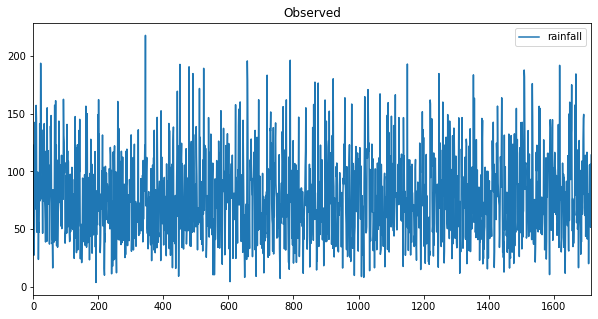

In [7]:
fig1 = data.plot(figsize=[10, 5])
fig1.set_title('Observed')
plt.show()

接着对原始时间序列数据进行变换：

In [8]:
# distributional transformation
transform1 = power_transformations(xt, 0.5)
transform2 = signed_power_transformation(xt, 0.5)

将处理过后的数据画图呈现：

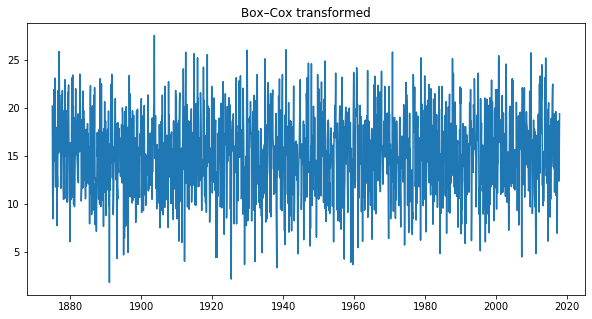

In [9]:
# plot
plt.figure(figsize=[10, 5])
plt.plot(t, transform2)
plt.title('Box–Cox transformed')
plt.show()

### 图2.7 英国酒销量的一次差分和二次差分

对于非平稳的时间序列，一个简单的的平稳变换方法是对原始数据进行一次差分和二次差分。

首先写出一次差分与二次差分的python代码：

In [10]:
def first_difference(xt):
    y = np.array([])
    for i in range(len(xt)-1):
        y = np.append(y, xt[i+1] - xt[i])
    return y


def second_differences(xt):
    y = np.array([])
    for i in range(len(xt) - 2):
        y = np.append(y, xt[i + 2] - 2 * xt[i+1] + xt[i])
    return y

本图我们选取英国的酒销售量作为处理数据，分别计算一次差分与二次差分。

首先读取wine spirit数据：

In [11]:
# read the data
data = pd.read_csv('data/wine_spirits.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

分别进行一次变换与二次变换：

In [12]:
# stationarity transformation
transform1 = first_difference(xt)
transform2 = second_differences(xt)

将原始数据、一次差分、二次差分以画图的形式展现：

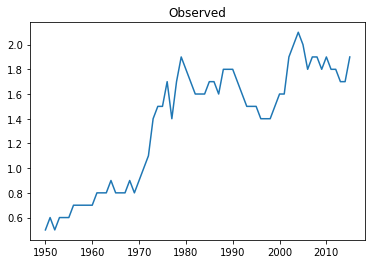

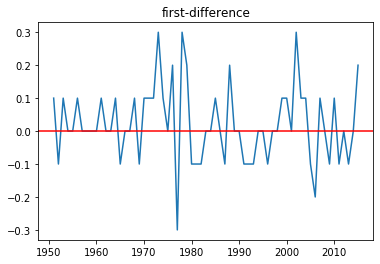

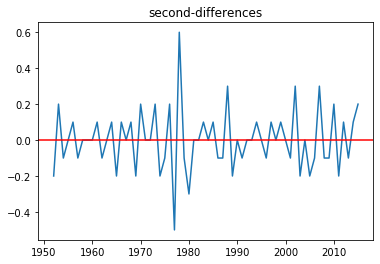

In [13]:
# plot
plt.figure(1)
plt.plot(t, xt)
plt.title('Observed')
plt.figure(2)
plt.plot(t[1:], transform1)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('first-difference')
plt.figure(3)
plt.plot(t[2:], transform2)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('second-differences')
plt.show()

### 图2.14 英国啤酒销量的时间序列分解及平滑变换

通常情况下，我们会关注时间序列一些主要的波动，对于一些“暂时性”波动，我们通常选择将其去除。Moving Average（MA）是平滑时间序列最为流行的处理方法。

MA的python代码具体实现如下：

In [14]:
def moving_average(xt, n):
    y = np.array([])
    if n % 2 == 1:
        for i in range(len(xt)-n+1):
            temp = 0
            for j in range(n):
                temp += xt[i+j]
            temp = temp / n
            y = np.append(y, temp)
        return y
    else:
        for i in range(len(xt)-n):
            temp = 0
            for j in range(n+1):
                if j == 0 or j == n:
                    temp += xt[i+j] / (2*n)
                else:
                    temp += xt[i+j] / n
            y = np.append(y, temp)
        return y

当观察到的时间序列有一定的季节性时，通常需要进行分解，将原始时间序列分解为：趋势$T_t$、季节性$S_t$和噪音$I_t$三部分。 在分解时，这三部分可以为加法：

$$
X_t=T_t+S_t+I_t
$$

也可以为乘法：

$$
X_t=T_t\times S_t\times I_t
$$

接下来我们选取英国啤酒销量的数据，对其进行平滑处理，并将其季节性元素进行分解。

首先读取beer.csv数据：

In [15]:
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = np.array(data.iloc[:, 1])

接着对数据进行平滑处理：

In [16]:
# stationarity transformation
transform1 = moving_average(xt, 5)

计算季节性分量与噪音分量：

In [17]:
diff = xt[2:-2] - transform1
s1 = s2 = s3 = s4 = []
for i in range(len(diff)):
    if (i+2) % 4 == 0:
        s1 = np.append(s1, diff[i])
    elif (i + 2) % 4 == 1:
        s2 = np.append(s2, diff[i])
    elif (i + 2) % 4 == 2:
        s3 = np.append(s3, diff[i])
    else:
        s4 = np.append(s4, diff[i])
s1 = np.mean(s1)
s2 = np.mean(s2)
s3 = np.mean(s3)
s4 = np.mean(s4)
season = np.tile([s1, s2, s3, s4],  len(t)//4+1)
irregular = diff - season[2:len(diff)+2]

将原始数据、季节性分量与噪音分量画图显示出来：

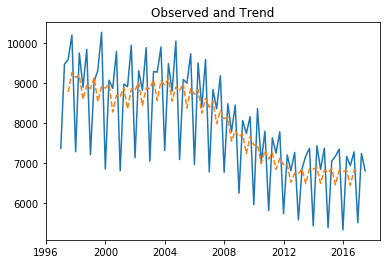

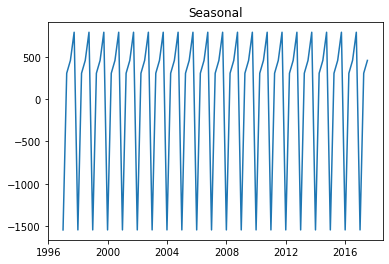

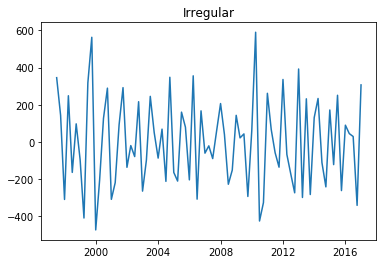

In [18]:
plt.figure(1)
plt.plot(t, xt, t[2:-2], transform1, '--')
plt.title('Observed and Trend')
plt.figure(2)
plt.plot(t, season[:len(t)])
plt.title('Seasonal')
plt.figure(3)
plt.plot(t[2:-2], irregular)
plt.title('Irregular')
plt.show()

## 第三章 平稳时间序列的ARMA模型

### 图3.1 AR(1) 模型的时间序列模拟与ACFs计算

自相关函数（ACF）用于评估时间序列数据是否依赖于其过去的数据。具体公式如下：

$$
\rho(k)=\frac{\gamma_k}{\gamma_0}=\frac{N}{N-k}*\frac{\sum_{t=k+1}^N(x_t-\mu)(x_{t-k}-\mu)}{\sum_{t=1}^N(x_t-\mu)(x_t-\mu)}
$$

具体的python代码实现如下：


In [19]:
def autocorrelation_function(k, xt):
    mean = np.mean(xt)
    var = np.var(xt)
    temp = 0
    for i in range(k, len(xt)):
        temp += (xt[i] - mean)*(xt[i-k] - mean)
    r = temp/(len(xt)*var)
    return r

**自回归模型**（AR），是统计上一种处理时间序列的方法，用之前的数据，去预测当前或未来的数据。

AR(1) 模型的具体公式为：

$$
x_t-\phi x_{t-1}=\alpha_t
$$

具体的python代码实现如下：

In [20]:
def autoregressive(phi, sigma, x0, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = x0[i]
    for i in range(k, n):
        temp = 0
        for t in range(k):
            temp += phi[t] * xt[i-t-1]
        xt[i] = temp + a[i] + const
    return xt

本图分别计算$\phi=0.5$和$\phi=-0.5$时的AR(1)模型，我们首先生成这两个AR(1)模型：

In [21]:
np.random.seed(1)
t = np.arange(100)
xt1 = autoregressive([0.5], 5, [0], 0, 100)
xt2 = autoregressive([-0.5], 5, [0], 0, 100)

分别画图展示$\phi=0.5$和$\phi=-0.5$时，k与$\rho$关系和t与$x_t$关系：

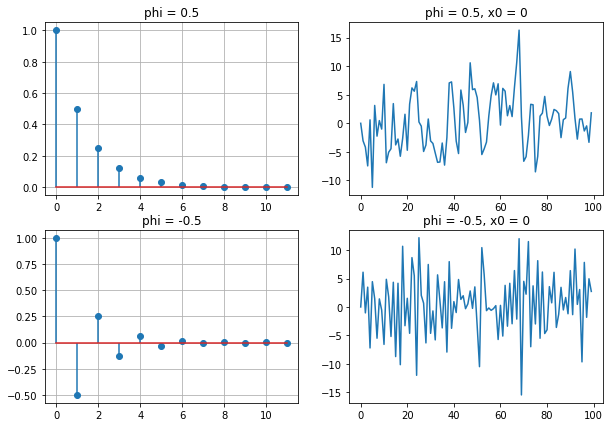

In [22]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 2, 1)
plt.grid(True)
plt.stem(np.power(0.5, np.arange(12)), use_line_collection=True)
plt.title("phi = 0.5")
plt.subplot(2, 2, 2)
plt.plot(t, xt1)
plt.title("phi = 0.5, x0 = 0")
plt.subplot(2, 2, 3)
plt.grid(True)
plt.stem(np.power(-0.5, np.arange(12)), use_line_collection=True)
plt.title("phi = -0.5")
plt.subplot(2, 2, 4)
plt.plot(t, xt2)
plt.title("phi = -0.5, x0 = 0")
plt.show()

### 图3.5 MA(1) 模型时间序列模拟

滑动平均模型（MA），是时间序列最为常见的模型之一。MA模型的公式如下：

$$
x_t=a_t-\theta_1a_{t-1}-...-\theta_qa_{t-q}
$$

python代码实现如下：

In [23]:
def moving_average(phi, sigma, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = a[i]
    for i in range(1, n):
        for t in range(k):
            if t == 0:
                temp = a[i]
            else:
                temp -= phi[t] * a[i - t]
        xt[i] = temp + const
    return xt

接下来分别生成两个MA(1)模型，并分别画图展示出来。

分别令$\theta=0.8$与$\theta=-0.8$，生成两个MA(1)时间序列：

In [24]:
t = np.arange(100)
xt1 = moving_average([0.8], 5, 0, 100)
xt2 = moving_average([-0.8], 5, 0, 100)

画图显示出两个MA(1)序列：

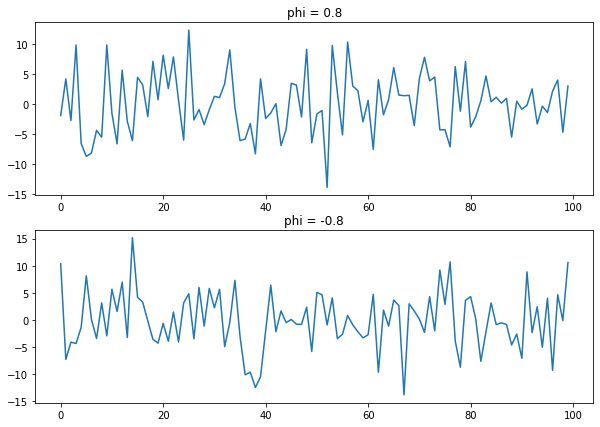

In [25]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt1)
plt.title("phi = 0.8")

plt.subplot(2, 1, 2)
plt.plot(t, xt2)
plt.title("phi = -0.8")
plt.show()

### 例3.1 北大西洋涛动(NAO)的ARMA模型

在计算本题之前，我们首先还要编写the partial ACF (PACF)的相关函数。

PACF可以由Yule-Walker方程中求得，具体的python代码实现如下：

In [26]:
def partial_autocorrelation_function(acf):
    k = len(acf)
    phi = np.empty([k, k])
    for i in range(k):
        if i == 0:
            phi[0][0] = acf[0]
        elif i == 1:
            phi[1][1] = (acf[1]-np.power(acf[0], 2))/(1-np.power(acf[0], 2))
        else:
            temp1 = temp2 = 0
            for j in range(i):
                if i-1 != j:
                    phi[i-1][j] = phi_calculate(phi, [i-1, j])
                temp1 += phi[i-1][j]*acf[i-j]
                temp2 += phi[i-1][j]*acf[j]
            phi[i][i] = (acf[i] - temp1) / (1 - temp2)
    return phi


def phi_calculate(phi, s):
    result = phi[s[0]-1, s[1]] - phi[s[0], s[0]]*phi[s[0]-1, s[0]-s[1]-1]
    return result

在本例题中，我们用NAO数据，通过计算不同阶数k时，对应ACF与PACF的估计值，从而估算出最适合的AR(k)与MA(k)模型。

首先读取nao.csv数据：

In [27]:
data = pd.read_csv('data/nao.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = np.array(data.iloc[:, 1])

阶数k的值分别取1到12，分别计算出每个k的对应ACF与PACF的估值:

In [28]:
step = 12
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [29]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

       k      r(k)   phi(kk)
0    1.0  0.186032  0.186032
1    2.0  0.054251  0.020347
2    3.0  0.006747  0.004574
3    4.0 -0.047786 -0.040892
4    5.0  0.024352  0.023905
5    6.0 -0.015865 -0.014433
6    7.0 -0.020269 -0.018789
7    8.0  0.009400  0.012191
8    9.0  0.044095  0.034971
9   10.0  0.040167  0.029838
10  11.0  0.030861  0.024698
11  12.0  0.058619  0.049870


根据数据可以得出，无论是AR模型还是MA模型，均在k为1时模型最为合适。

接着我们根据计算出系数，分别生成AR(1)与MA(1)模型：

In [30]:
ar_data = autoregressive(phi[0:1], 0.994, xt[0:1], 0, len(xt))
ma_data = autoregressive([0.175], 0.995, xt[0:1], 0, len(xt))

将原始数据、AR模型数据、MA模型数据以画图形式展现：

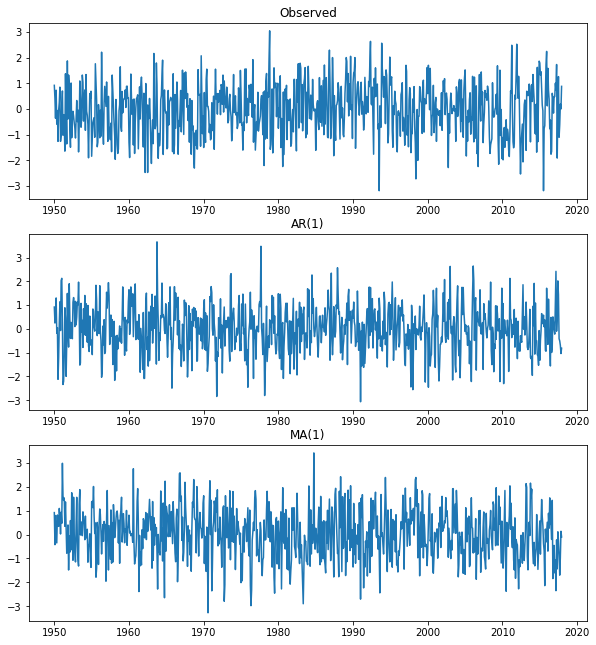

In [31]:
plt.figure(figsize=[10, 11])
plt.subplot(3, 1, 1)
plt.plot(t, xt)
plt.title('Observed')
plt.subplot(3, 1, 2)
plt.plot(t, ar_data)
plt.title('AR(1)')
plt.subplot(3, 1, 3)
plt.plot(t, ma_data)
plt.title('MA(1)')
plt.show()

### 例3.2 模拟英国利率数据

本题中用到了ARMA模型。ARMA模型是AR模型与MA模型的结合，具体公式如下：

$$
x_t-\phi_1x_{t-1}-...-\phi_px_{t-p}=a_t-\theta_1a_{t-1}-...-\theta_qa_{t-q}
$$

代码实现如下：

In [32]:
def autoregressive_moving_average(phi, theta, sigma, x0, const, n):
    k1 = len(phi)
    k2 = len(theta)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k1):
        xt[i] = x0[i]
    for i in range(k1, n):
        temp = 0
        for t in range(k1):
            temp += phi[t] * xt[i - t - 1]
        for t in range(k2):
            if t == 0:
                temp += a[i]
            else:
                temp -= phi[t] * a[i - t]
        xt[i] = temp + const
    return xt

本题使用了英国利率20年期数据(R20)，通过计算不同阶数k时，对应ACF与PACF的估计值，从而估算出最适合的ARMA模型。

首先读取interest_rates.csv中的R20数据：

In [33]:
data = pd.read_csv('data/interest_rates.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y/%m/%d')
xt = data.iloc[:, 1]

阶数k的值分别取1到12，分别计算出每个k的对应ACF与PACF的估值:

In [34]:
step = 12
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [35]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

       k      r(k)   phi(kk)
0    1.0  0.994248  0.994248
1    2.0  0.986679 -0.161419
2    3.0  0.979405  0.690746
3    4.0  0.972704 -0.112676
4    5.0  0.966307  0.043131
5    6.0  0.959816  0.011819
6    7.0  0.953113 -0.003728
7    8.0  0.946678 -0.022793
8    9.0  0.940476  0.015553
9   10.0  0.933995  0.018419
10  11.0  0.927022 -0.008801
11  12.0  0.919938 -0.027462


并将数据以画图的形式展现：

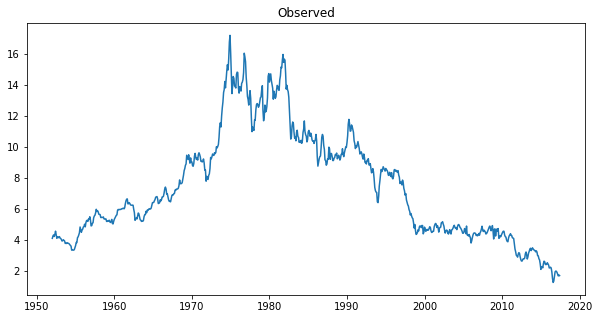

In [36]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('Observed')
plt.show()

### 例3.3 模拟太阳黑子数

本题使用了太阳黑子数据，通过计算不同阶数k时，对应ACF与PACF的估计值，从而估算出最适合的ARMA模型。

首先读取sunspots.csv的数据：

In [37]:
data = pd.read_csv('data/sunspots.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

阶数k的值分别取1到9，分别计算出每个k的对应ACF与PACF的估值:

In [38]:
step = 9
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [39]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

     k      r(k)   phi(kk)
0  1.0  0.813871  0.813871
1  2.0  0.432408 -0.681187
2  3.0  0.008963  1.609507
3  4.0 -0.316090 -0.914666
4  5.0 -0.471612 -0.005998
5  6.0 -0.425768  0.872953
6  7.0 -0.206716  1.564865
7  8.0  0.113062  0.841875
8  9.0  0.434202  0.722630


将数据以画图的形式展现：

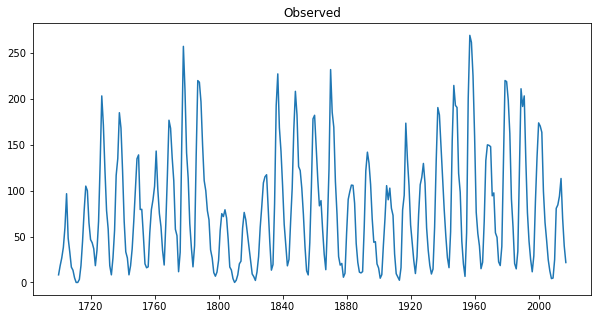

In [40]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('Observed')
plt.show()

## 第四章 非平稳时间序列的ARIMA模型

### 图4.1 模拟线性序列和二次序列

在本题中，我们分别生成一次线性序列与二次序列：

$$
\begin{align}
M1: \quad &x_t=10+2t+a_t \\
M2: \quad &x_t=10+5t-0.03t^2+a_t
\end{align}
$$

接下来我们将用python生成这两个序列，并画图显示。首先定义生成序列：

In [41]:
n = 100
t = np.arange(n)
a = np.random.normal(0, 9, n)
xt1 = 10 + 2 * t + a
xt2 = 10 + 5 * t - 0.03 * np.power(t, 2) + a

将序列以画图形式呈现：

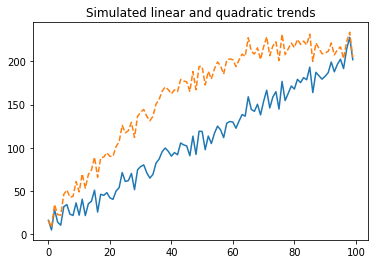

In [42]:
plt.figure()
plt.plot(t, xt1, t, xt2, '--')
plt.title('Simulated linear and quadratic trends')
plt.show()

### 图4.3 模拟随机游走

首先，随机游走(Random Walk)的公式可以写成如下形式：

$$
x_t=x_{t-1}+a_t
$$

带漂移项的随机游走(Random Walk with drift)可以写为：

$$
x_t=x_{t-1}+\theta_0+a_t
$$

将随机游走用python代码实现，得：

In [43]:
def random_walk(x0, sigma, const, n):
    a = np.random.normal(0, sigma, n)
    xt = np.zeros(n)
    xt[0] = x0
    for i in range(1, n):
        xt[i] = xt[i-1] + a[i] + const
    return xt

接下来，我们分别实现起始项$x_0=10$，带漂移项$\theta=2$与不带漂移项的两种随机游走。

首先设置对应参数：

In [44]:
n = 100
x0 = 10
sigma = 9
const = 2
t = np.arange(n)

分别实现两种随机游走，并画图显示：

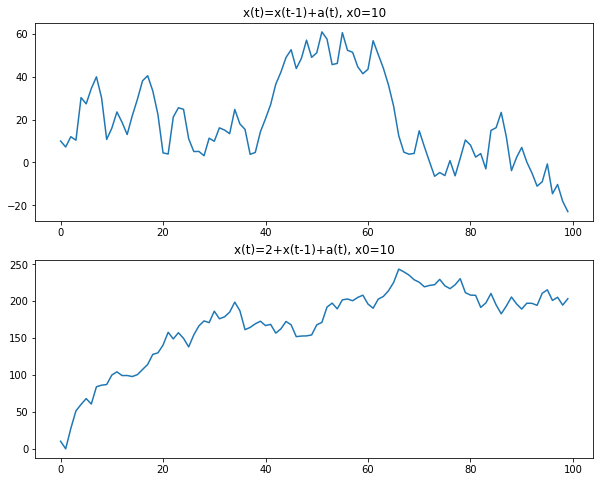

In [45]:
plt.figure(figsize=[10, 8])
plt.subplot(2, 1, 1)
plt.plot(t, random_walk(x0, sigma, 0, n))
plt.title('x(t)=x(t-1)+a(t), x0=10')
plt.subplot(2, 1, 2)
plt.plot(t, random_walk(x0, sigma, const, n))
plt.title('x(t)=2+x(t-1)+a(t), x0=10')
plt.show()

### 图4.5 模拟二次差分带漂移项模型

首先我们先要了解ARIMA模型，ARIMA模型是在ARMA模型的基础上，增加了差分项，使原本非平稳时间序列变为平稳时间序列。

ARIMA的公式可以写为：

$$
\phi(B)\nabla^dx_t=\theta_0+\theta(B)a_t
$$

用python代码实现，可以得到：

In [46]:
def autoregressive_integrated_moving_average(d, phi, theta, sigma, x0, const, n):
    k1 = len(phi)
    k2 = len(theta)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k1):
        xt[i] = x0[i]
    for i in range(k1, n):
        temp = 0
        for t in range(k1):
            temp += phi[t] * xt[i - t - 1]
        for t in range(k2):
            if t == 0:
                temp += a[i]
            else:
                temp -= theta[t] * a[i - t]
        xt[i] = temp + const
    for i in range(len(x0)):
        xt[i] = x0[i]
    xt = difference_calculate(xt, d)
    return xt


def difference_calculate(xt, d):
    if d == 0:
        return xt
    if d == 1:
        for i in range(1, len(xt)):
            xt[i] = xt[i-1] + xt[i]
        return xt
    if d == 2:
        for i in range(2, len(xt)):
            temp = xt[i] + 2 * xt[i-1] - xt[i-2]
            xt[i] = temp
        return xt

根据要求，我们用ARIMA生成$\nabla^2x_t=2+a_t$序列：

In [47]:
xt = autoregressive_integrated_moving_average(2, [1], [1], 3, [10, 10], 2, 100)

将所得的$x_t$画图展示出来：

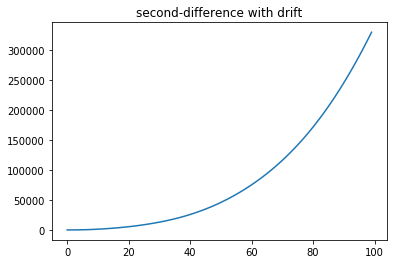

In [48]:
plt.figure()
plt.plot(t, xt)
plt.title('second-difference with drift')
plt.show()

### 例4.1 英国利率作为综合过程建模

本题在英国利率数据一次差分的基础上进行建模，对R20进行一次差分处理，并利用ARIMA(p,1,q)模型进行接下来的计算。

首先导入第三章所写的ACF与PACF相关的函数：

In [49]:
def first_difference(xt):
    y = np.array([])
    for i in range(len(xt)-1):
        y = np.append(y, xt[i+1] - xt[i])
    return y


def autocorrelation_function(k, xt):
    mean = np.mean(xt)
    var = np.var(xt)
    temp = 0
    for i in range(k, len(xt)):
        temp += (xt[i] - mean) * (xt[i - k] - mean)
    r = temp / (len(xt) * var)
    return r


def partial_autocorrelation_function(acf):
    k = len(acf)
    phi = np.empty([k, k])
    for i in range(k):
        if i == 0:
            phi[0][0] = acf[0]
        elif i == 1:
            phi[1][1] = (acf[1]-np.power(acf[0], 2))/(1-np.power(acf[0], 2))
        else:
            temp1 = temp2 = 0
            for j in range(i):
                if i-1 != j:
                    phi[i-1][j] = phi_calculate(phi, [i-1, j])
                temp1 += phi[i-1][j]*acf[i-j]
                temp2 += phi[i-1][j]*acf[j]
            phi[i][i] = (acf[i] - temp1) / (1 - temp2)
    return phi


def phi_calculate(phi, s):
    result = phi[s[0]-1, s[1]] - phi[s[0], s[0]]*phi[s[0]-1, s[0]-s[1]-1]
    return result

我们导入interest_rates.csv中的R20数据，并做一次差分：

In [50]:
data = pd.read_csv('data/interest_rates.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')[1:]
xt = first_difference(data.iloc[:, 1])

阶数k的值分别取1到12，分别计算出每个k的对应ACF与PACF的估值:

In [51]:
step = 12
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [52]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

       k      r(k)   phi(kk)
0    1.0  0.270060  0.270060
1    2.0 -0.044117 -0.126258
2    3.0 -0.076490 -0.064448
3    4.0 -0.028475 -0.034102
4    5.0  0.030240  0.013784
5    6.0  0.020680  0.015483
6    7.0 -0.054867 -0.037965
7    8.0 -0.053433 -0.045029
8    9.0  0.013648 -0.001669
9   10.0  0.060316  0.037693
10  11.0  0.042241  0.038296
11  12.0  0.037809  0.045606


将一次差分的数据画图展现：

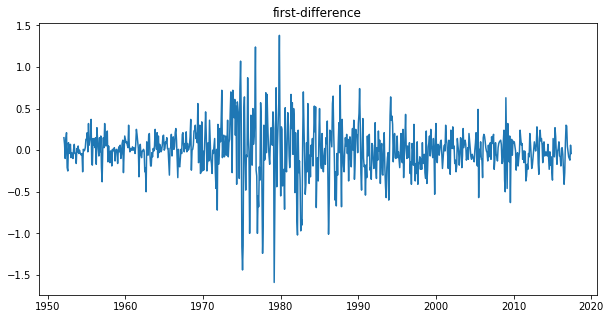

In [53]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('first-difference')
plt.show()

### 例4.2 英镑与美元之间的汇率建模

与上一例题步骤相似。我们本题中使用dollar数据，对k为1到50的值进行计算。

首先读取dollar.csv数据：

In [54]:
data = pd.read_csv('data/dollar.csv')
t = pd.date_range('1975-01-01', periods=len(data))
xt = np.array(data)

阶数k的值分别取1到50，分别计算出每个k的对应ACF与PACF的估值:

In [55]:
step = 50
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [56]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

       k      r(k)   phi(kk)
0    1.0  0.998666  0.998666
1    2.0  0.997213 -0.045198
2    3.0  0.995783  0.546109
3    4.0  0.994374 -0.020611
4    5.0  0.992966  0.004836
5    6.0  0.991542  0.000040
6    7.0  0.990092 -0.002920
7    8.0  0.988638 -0.005441
8    9.0  0.987178 -0.000681
9   10.0  0.985719 -0.001727
10  11.0  0.984251  0.000422
11  12.0  0.982795 -0.002925
12  13.0  0.981360  0.002019
13  14.0  0.979900  0.004749
14  15.0  0.978387 -0.004533
15  16.0  0.976841 -0.009866
16  17.0  0.975273 -0.006127
17  18.0  0.973688 -0.004314
18  19.0  0.972141 -0.004904
19  20.0  0.970569  0.009152
20  21.0  0.968943 -0.004497
21  22.0  0.967302 -0.010678
22  23.0  0.965687 -0.003714
23  24.0  0.964121  0.004073
24  25.0  0.962559  0.009539
25  26.0  0.960985  0.000341
26  27.0  0.959400 -0.002365
27  28.0  0.957774 -0.001107
28  29.0  0.956104 -0.007642
29  30.0  0.954425 -0.008755
30  31.0  0.952746 -0.001560
31  32.0  0.951077 -0.000535
32  33.0  0.949385  0.002545
33  34.0  0.94

将原始数据画图展现：

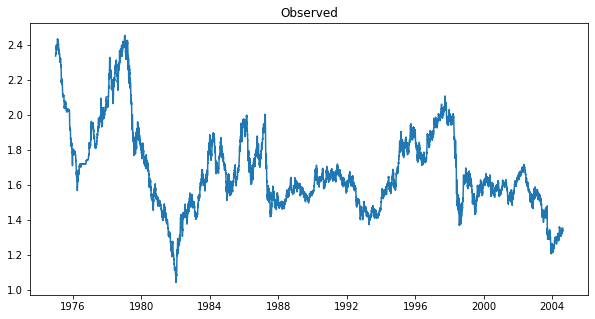

In [57]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('Observed')
plt.show()

### 例4.3 全球温度建模

本题对全球温度数据一次差分的基础上进行建模，并利用ARIMA(p,1,q)模型进行预测。

首先读取global_temps.csv：

In [58]:
np.random.seed(3)
data = pd.read_csv('data/global_temps.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = first_difference(data.iloc[:, 1])

阶数k的值分别取1到20，分别计算出每个k的对应ACF与PACF的估值:

In [59]:
step = 20
k = np.arange(1, step+1, 1)
r = np.zeros(step)
phi = np.zeros(step)
for i in range(1, step+1):
    r[i-1] = autocorrelation_function(i, xt)
phi = np.diag(partial_autocorrelation_function(r))

将计算结果以pandas列表形式打印出来：

In [60]:
result = pd.DataFrame(np.array([k, r, phi]).transpose())
result.columns = ['k', 'r(k)', 'phi(kk)']
print(result)

       k      r(k)   phi(kk)
0    1.0 -0.354504 -0.354504
1    2.0 -0.027931 -0.175682
2    3.0 -0.060827 -0.107496
3    4.0 -0.000131 -0.019933
4    5.0 -0.016806 -0.038267
5    6.0 -0.002966 -0.013783
6    7.0  0.017231  0.022791
7    8.0 -0.035625 -0.057764
8    9.0 -0.011553 -0.030474
9   10.0  0.035570  0.047190
10  11.0 -0.018657 -0.024573
11  12.0 -0.004938 -0.009684
12  13.0  0.052562  0.084477
13  14.0  0.007793  0.034557
14  15.0 -0.036708 -0.047934
15  16.0 -0.057710 -0.109906
16  17.0  0.027801  0.026538
17  18.0 -0.007248 -0.022364
18  19.0  0.026720  0.041143
19  20.0 -0.027729 -0.037068


接下来根据我们的预测，得到了以下ARIMA(0,1,3)模型：

$$
\nabla x_t=0.00052+\hat{a}_t-0.506\hat{a}_{t-1}-0.090\hat{a}_{t-2}-0.119\hat{a}_{t-3} \qquad \hat{\sigma}=0.1236
$$

用python代码进行预测，得：

In [61]:
# predict
y = autoregressive_integrated_moving_average(1, [], [0.506, 0.090, 0.119], 0.1236, xt[0:1], 0.00052, len(xt))

将预测结果，ACF的值、PACF的值画图，得到以下结果：

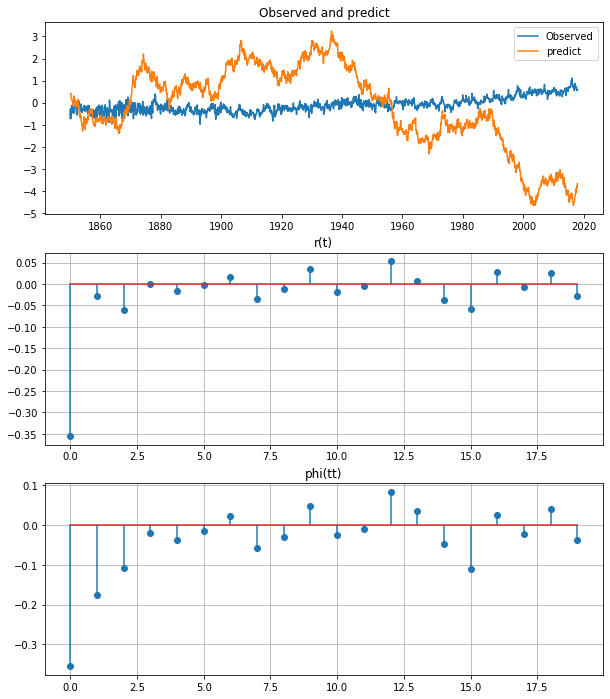

In [62]:
plt.figure(figsize=[10, 12])
plt.subplot(3, 1, 1)
plt.plot(t, data.iloc[:, 1])
plt.plot(t[1:], y)
plt.legend(['Observed', 'predict'])
plt.title('Observed and predict')
plt.subplot(3, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.title('r(t)')
plt.subplot(3, 1, 3)
plt.grid(True)
plt.stem(phi, use_line_collection=True)
plt.title('phi(tt)')
plt.show()

## 第五章 单位根，差异和趋势的平稳性和分数差分

### 例5.1 英镑与美元之间的汇率的单位根测试

单位根(Unit Root)是用于检验时间序列是否为平稳时间序列。可以证明，序列中存在单位根过程就不平稳，会使回归分析中存在伪回归。

单位根的具体计算公式如下：

$$
\tau_\mu=\frac{\hat{\phi}_T-1}{se(\hat{\phi_T})}
$$

python代码实现如下：

In [63]:
def unit_root(phi, xt):
    t = len(xt)
    k = len(phi)
    temp1 = temp2 = 0
    for i in range(1, t):
        temp1 += np.power(xt[i-1], 2)
        temp3 = xt[i]
        for j in range(k):
            temp3 -= phi[j]*xt[i-j-1]
        temp2 += np.power(temp3, 2)
    st2 = temp2 / (t-1)
    se = np.power((st2 / temp1), 0.5)
    tau = (np.sum(phi)-1) / se
    return tau

本题选用了英国汇率数据，计算模型中是否存在单位根。

首先读取interest_rates.csv：

In [64]:
data = pd.read_csv('data/interest_rates.csv')
t = pd.date_range('1975-01-01', periods=len(data))
xt = np.array(data.iloc[:, 1])

计算对应的$\tau$值：

In [65]:
tau = unit_root([1.193, -0.224], xt)
print('tau = ', tau)

tau =  -18.990882068484037


将原始数据以画图形式展现：

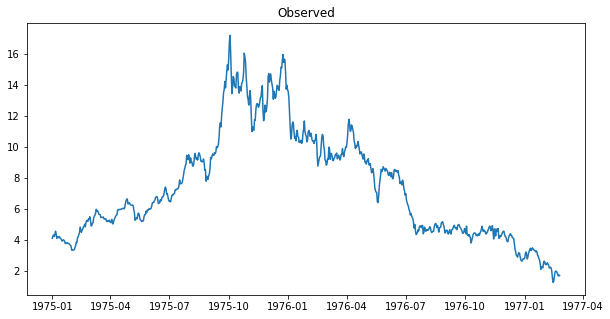

In [66]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('Observed')
plt.show()

### 例5.5 对英国GDP的冲击是暂时的还是永久的？

首先我们读取英国的gdp数据：

In [67]:
data = pd.read_csv("data/gdp.csv")
t = np.arange(1270, 1914, 1)
xt = data.iloc[:, 1]
data.head()

,t,gdp
0,1270/1/1,0.483038
1,1271/1/1,0.477300
2,1272/1/1,0.494482
3,1273/1/1,0.465640
4,1274/1/1,0.463213


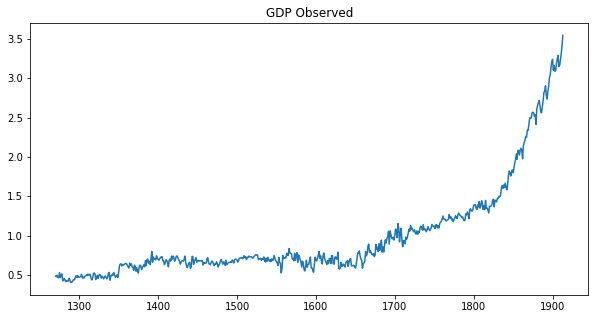

In [68]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('GDP Observed')
plt.show()

接下来我们对原始数据进行ADF检验：

In [69]:
#平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF


print('原始序列的ADF检验结果为：', ADF(xt))

原始序列的ADF检验结果为： (7.148596451333219, 1.0, 6, 637, {'1%': -3.44065745275905, '5%': -2.8660879520543534, '10%': -2.5691919933016076}, -2001.716037063169)


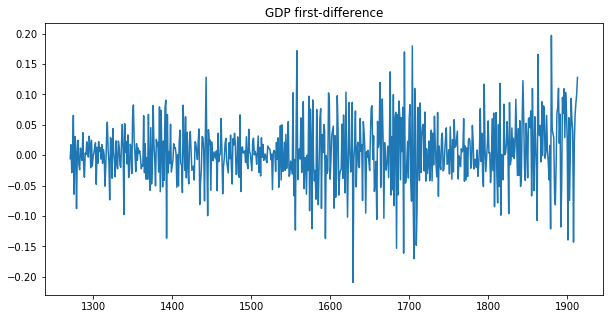

In [70]:
#进行一阶差分
diff1 = np.diff(xt)
plt.figure(figsize=[10, 5])
plt.plot(t[1:], diff1)
plt.title('GDP first-difference')
plt.show()

In [71]:
adf1 = ADF(diff1)
print(u'原始序列的ADF检验结果为：', adf1)

原始序列的ADF检验结果为： (-2.9545365518680833, 0.03936379988826862, 17, 625, {'1%': -3.440856177517568, '5%': -2.86617548304384, '10%': -2.56923863104}, -1972.9453750964813)


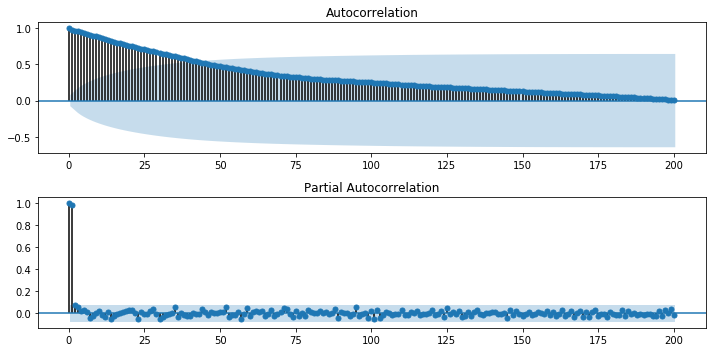

In [72]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = plot_acf(xt,lags=200,ax=ax1)
fig.tight_layout()
ax2 = fig.add_subplot(212)
fig = plot_pacf(xt,lags=200,ax=ax2)
fig.tight_layout()

接下来进行白噪声检测：

In [73]:
#白噪声检测
from statsmodels.stats.diagnostic import acorr_ljungbox


print(u'差分序列的白噪声检验结果为：', acorr_ljungbox(diff1, lags=1)) #返回统计量和p值

差分序列的白噪声检验结果为： (array([30.39857712]), array([3.51786102e-08]))


由以上结果可以得出:一阶差分后的时间序列是平稳非白噪声的时间序列数据。

In [74]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(diff1, order=(2,2)).fit() 

print(model.bic,model.aic,model.hqic)
#aic  bic hqic越小越好

-2003.2450185759014 -2030.0418869213272 -2019.6429261845637


## 第六章 不连续趋势模型与非线性模型

### 例6.2 美国股票的转折点预测

In [75]:
data = pd.read_csv("data/interest_rates.csv")
data.head()

,t,r20,rs,c
0,1952/1/1,4.11,0.994750,-0.012296
1,1952/2/1,4.26,1.028250,0.233268
2,1952/3/1,4.33,2.365042,-0.081877
3,1952/4/1,4.23,2.317500,-0.113973
4,1952/5/1,4.36,2.350833,0.007990


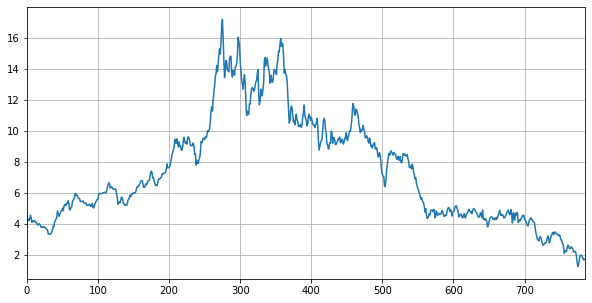

In [76]:
plt.figure(figsize=(10,5))
data.iloc[:, 1].plot(grid=True)
plt.show()

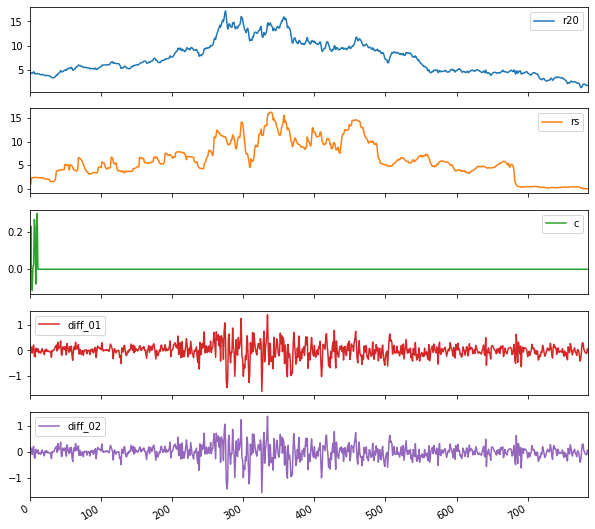

In [77]:
#一阶差分
data['diff_01'] = data.iloc[:, 1].diff(1)
#二阶差分
data['diff_02'] = data.iloc[:, 1].diff(1)
data.plot(subplots=True,figsize=(10,10))
plt.show()

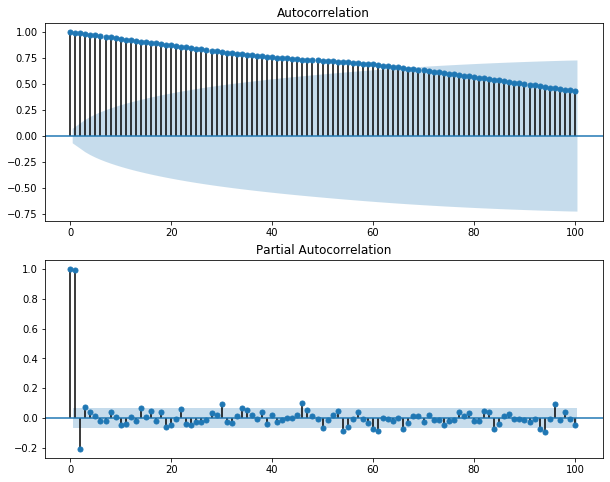

In [78]:
#修改时间序列的时间索引
df = pd.DataFrame(data) 
df.index = pd.DatetimeIndex(start=df.iloc[:, 0][0],periods=len(df.iloc[:, 0]),freq='MS')  #生成日期索引
ts = df.iloc[:, 1]  # 生成pd.Series对象

def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
diff = ts.diff(1)
diff = ts.fillna(0)

autocorrelation(diff, 100)

下面我们对时间序列分别：分解为趋势项、季节性以及残差三项

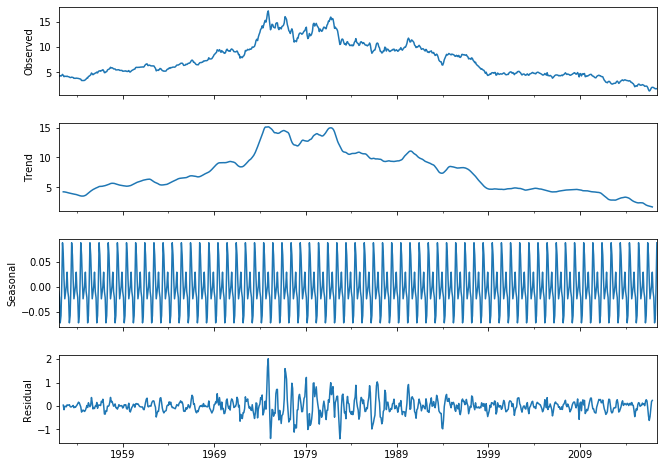

In [79]:
decomposition = seasonal_decompose(ts)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
fig = decomposition.plot()  
fig.set_size_inches(10, 7)

AIC 准则全称是最小化信息量准则（Akaike Information Criterion）,其中 L 表示模型的极大似然函数， K 表示模型参数个数。
AIC 准则存在一定的不足。

当样本容量很大时，在 AIC 准则中拟合误差提供的信息就要受到样本容量的放大，而参数个数的惩罚因子却和样本容量没关系（一直是2），因此当样本容量很大时，使用 AIC 准则的模型不收敛于真实模型，它通常比真实模型所含的未知参数个数要多。BIC（Bayesian InformationCriterion）贝叶斯信息准则弥补了 AIC 的不足：其中 n 表示样本容量。


显然，这两个评价指标越小越好。我们通过网格搜索，确定 AIC、BIC 最优的模型（p、q）

In [80]:
trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

trend_evaluate = sm.tsa.arma_order_select_ic(trend, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

residual_evaluate = sm.tsa.arma_order_select_ic(residual, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

trend AIC (2, 1)
trend BIC (2, 1)
residual AIC (3, 1)
residual BIC (3, 1)


从评价准则的结果看（这里采用 AIC 结果）：

（1）对趋势序列，p = 4， q = 3

（2）对残差序列，p = 3， q = 1

### 例6.3 美国股票价格的LSTR和Fourier模型

首先读取美元数据dollar.csv：

In [81]:
data = pd.read_csv("data/dollar.csv")
data.tail()

,dollar
10814,1.3354
10815,1.3387
10816,1.3399
10817,1.3436
10818,1.3510


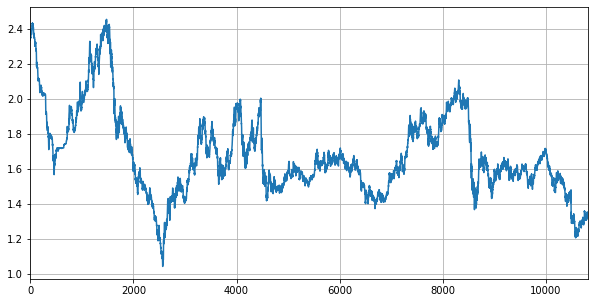

In [82]:
plt.figure(figsize=(10,5))
data['dollar'].plot(grid=True)
plt.show()

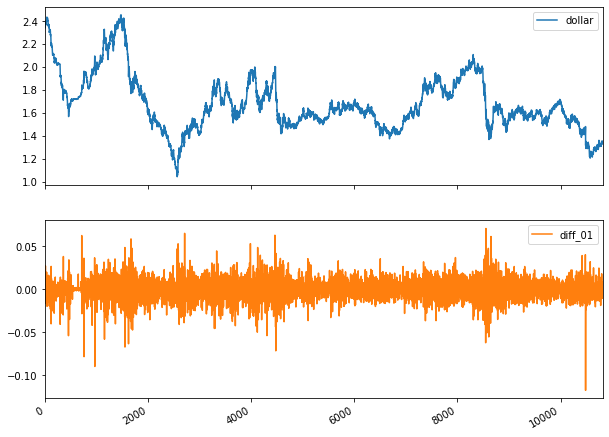

In [83]:
data['diff_01'] = data['dollar'].diff(1)
data.plot(subplots=True,figsize=(10,8))
plt.show()

下面我们对时间序列分别：分解为趋势项、季节性以及残差三项：

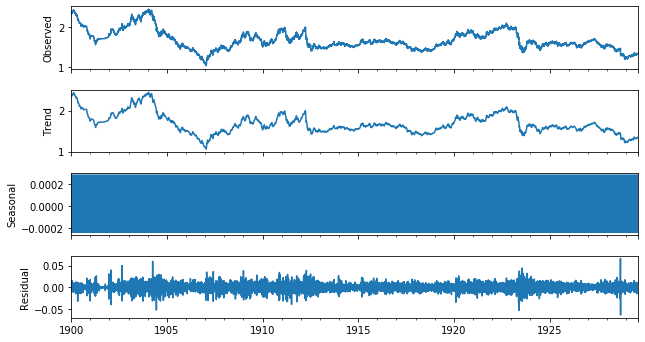

In [84]:
data.index = pd.date_range('1900-1-1',periods=len(data))
ts = data.iloc[:, 0]
#对时间序列进行分解
decomposition = seasonal_decompose(ts)
#趋势项
trend = decomposition.trend
#季节性
seasonal = decomposition.seasonal
#残差
residual = decomposition.resid

fig = decomposition.plot()  
fig.set_size_inches(10, 5)

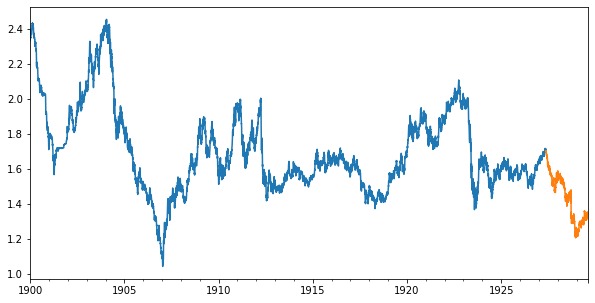

In [85]:
#切割数据
train = ts[0:10000]
test = ts[10000:]
#按天采样
train = train.resample('D').mean()
test = test.resample('D').mean()

train.plot(figsize=(10,5))
test.plot(figsize=(10,5))
plt.show()

下面用朴素法对数据进行预测：

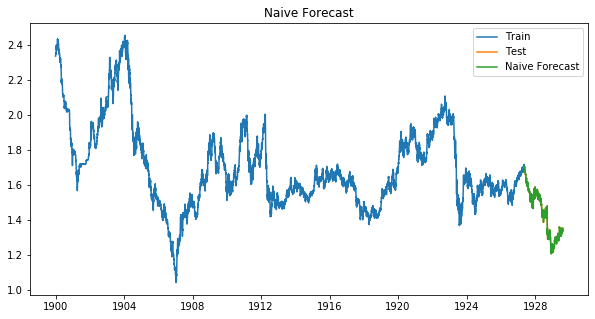

In [86]:
dd = np.asarray(train)
y_hat = test.copy()
plt.figure(figsize=(10, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(y_hat.index, y_hat, label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

### 例6.5 Box and Jenkins’ Series预测

In [87]:
data = pd.read_csv("data/bj_series_c.csv")
data.head()

,series_c
0,26.6
1,27.0
2,27.1
3,27.1
4,27.1


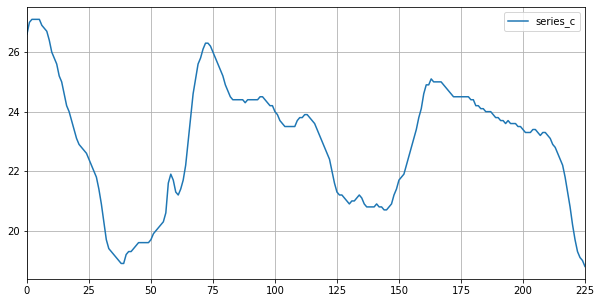

In [88]:
data.plot(figsize=(10,5), grid=True)

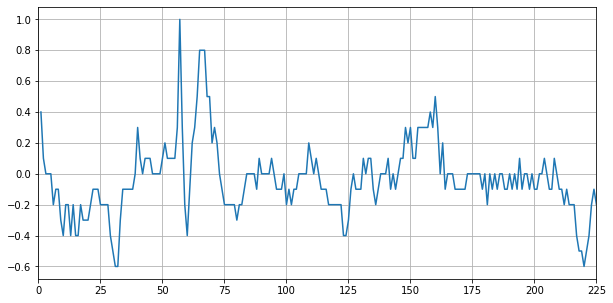

In [89]:
#一阶差分
data['diff'] = data.diff(1)
data['diff'].plot(figsize=(10,5),grid=True)

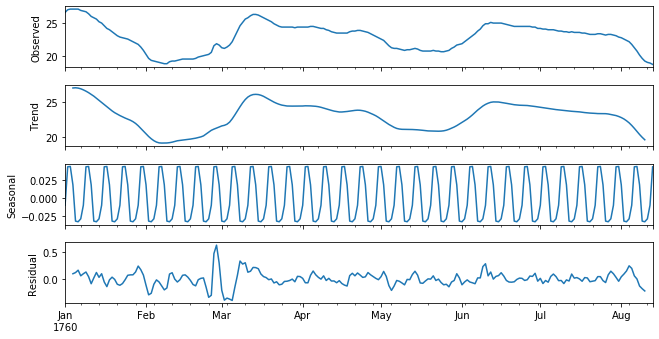

In [90]:
df = pd.DataFrame(data)
df.index = pd.date_range('1760-1-1',periods=len(data))
ts = df.iloc[:, 0]
#对时间序列进行分解
decomposition = seasonal_decompose(ts)
#趋势项
trend = decomposition.trend
#季节性
seasonal = decomposition.seasonal
#残差
residual = decomposition.resid

fig = decomposition.plot()  
fig.set_size_inches(10, 5)

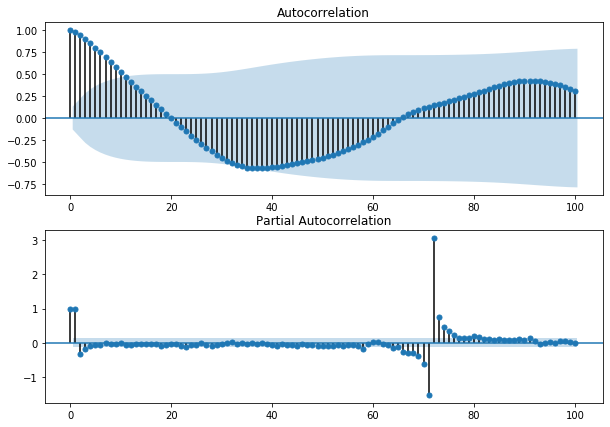

In [91]:
def autocorrelation(timeseries, lags):
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries, lags=lags, ax=ax2)
    plt.show()
    
diff = ts.diff(1)
diff = ts.fillna(0)

autocorrelation(diff, 100)

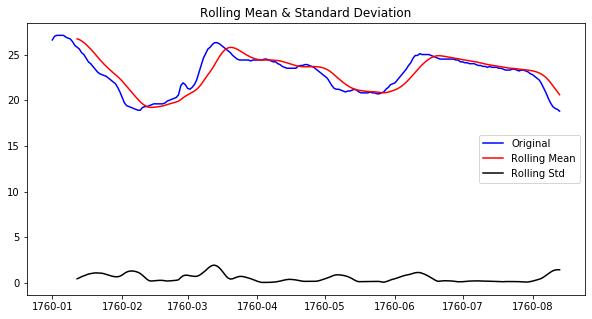

Results of Dickey-Fuller Test:
Test Statistic                  -2.852941
p-value                          0.051100
#Lags Used                       1.000000
Number of Observations Used    224.000000
Critical Value (1%)             -3.459885
Critical Value (5%)             -2.874531
Critical Value (10%)            -2.573694
dtype: float64


In [92]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(ts)

In [93]:
mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(1,1,1), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           series_c   No. Observations:                  226
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 109.145
Date:                            Sat, 15 Aug 2020   AIC                           -210.291
Time:                                    16:36:56   BIC                           -196.846
Sample:                                01-01-1760   HQIC                          -204.857
                                     - 08-13-1760                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8101      0.033     24.745      0.000       0.746       0.874
ma.L1          0.0736      0.052   

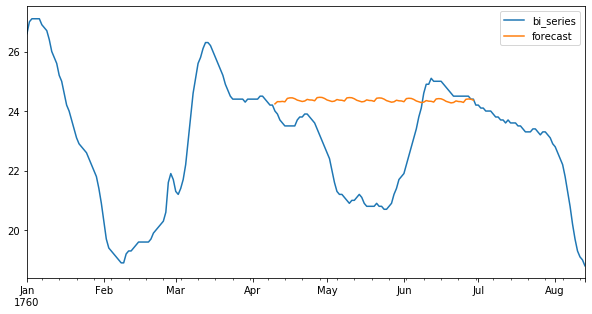

In [94]:
#做预测
df['forecast'] = results.predict(start = 100, end= 180, dynamic= True)  
df['bi_series'] = df.iloc[:, 0]
df[['bi_series', 'forecast']].plot(figsize=(10, 5))

## 第七章 单变量模型预测

### 例7.3 加尼福利亚降雨量预测

首先读取kefalonia.csv数据：

In [95]:
data = pd.read_csv("data/kefalonia.csv")
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]
data.tail()

,t,rainfall
175,2017-08-01,0.0
176,2017-09-01,24.2
177,2017-10-01,27.0
178,2017-11-01,202.0
179,2017-12-01,152.0


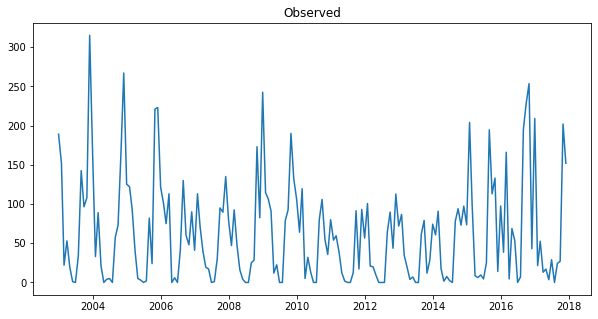

In [96]:
plt.figure(figsize=[10, 5])
plt.plot(t, xt)
plt.title('Observed')
plt.show()

<Figure size 432x288 with 0 Axes>

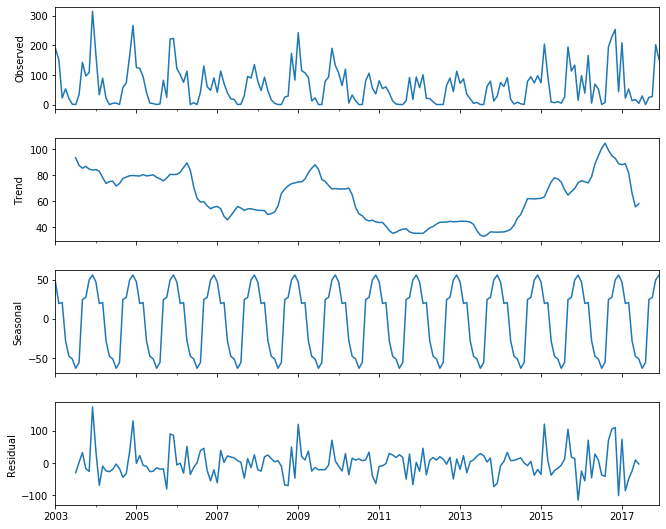

In [97]:
df = pd.DataFrame(data) 
df.index = pd.DatetimeIndex(start=t[0],periods=len(t),freq='MS')  #生成日期索引
ts = df.iloc[:, 1]

#对时间序列进行分解
decomposition = seasonal_decompose(ts)
#趋势项
trend = decomposition.trend
#季节性
seasonal = decomposition.seasonal
#残差
residual = decomposition.resid

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 8)

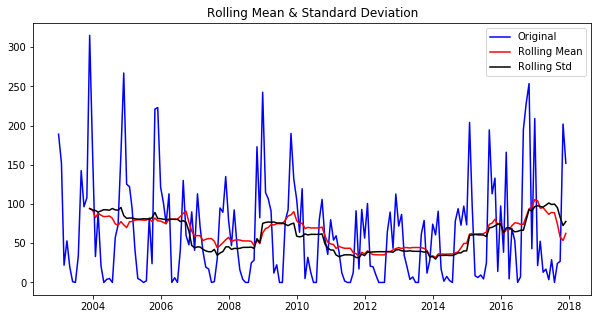

Results of Dickey-Fuller Test:
Test Statistic                  -2.585620
p-value                          0.096006
#Lags Used                      11.000000
Number of Observations Used    168.000000
Critical Value (1%)             -3.469886
Critical Value (5%)             -2.878903
Critical Value (10%)            -2.576027
dtype: float64


In [98]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(10, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')  #autolag : {‘AIC’, ‘BIC’, ‘t-stat’, None}
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(ts)

从P值可以看出：序列并不平稳。

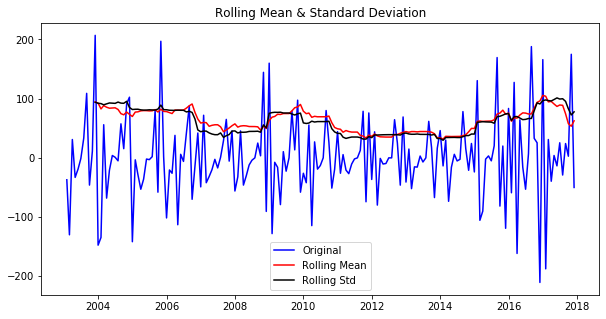

Results of Dickey-Fuller Test:
Test Statistic                -1.244397e+01
p-value                        3.699816e-23
#Lags Used                     1.000000e+01
Number of Observations Used    1.680000e+02
Critical Value (1%)           -3.469886e+00
Critical Value (5%)           -2.878903e+00
Critical Value (10%)          -2.576027e+00
dtype: float64


In [99]:
diff1 = ts - ts.shift(1)
test_stationarity(diff1.dropna(inplace=False))

从p值看出经过差分处理后是平稳的。

In [100]:
mod = sm.tsa.statespace.SARIMAX(ts, trend='n', order=(1,1,1), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           rainfall   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -895.534
Date:                            Sat, 15 Aug 2020   AIC                           1799.068
Time:                                    16:36:58   BIC                           1811.540
Sample:                                01-01-2003   HQIC                          1804.130
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1083      0.063      1.718      0.086      -0.015       0.232
ma.L1         -0.9495      0.025   

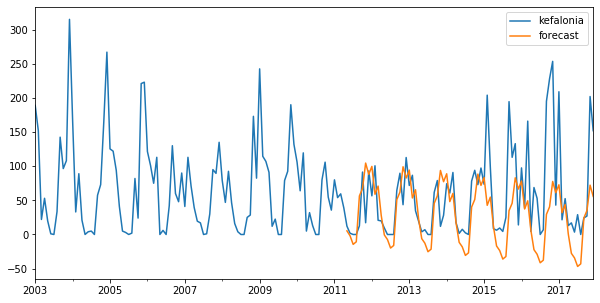

In [101]:
#做预测
df['kefalonia'] = ts
df['forecast'] = results.predict(start = 100, end= 180, dynamic= True)  
df[['kefalonia', 'forecast']].plot(figsize=(10, 5))

## 第八章 不可观测的组件模型，信号提取和滤波器

### 例8.1 不可观测的组件模型

差异平稳时间序列可以分解为随机的非平稳趋势，或信号，分量和平稳噪声，或不规则分量：

$$x_t = z_t+u_t$$

### 例8.2 H-P滤波法处理全球温度数据

不可观测的组件模型也与H-P滤波器有关，这是一种使经济时间序列趋于趋势化的流行方法。 该过滤器是通过将噪声分量$u_t=x_t-z_t$最小化而得出的，该最小化问题可以转变为函数最小化的问题：

$$
\sum_{t=1}^tu_t^2+\lambda\sum_{t=1}^T((z_{t+1}-z_t)-(z_t-z_{t-1}))^2
$$

其中λ是拉格朗日乘数，可以解释为平滑度参数。λ值越高，趋势越平滑，因此在极限情况下，随着λ~N，$z_t$逐渐趋于线性。 一阶情况下的条件为：

$$
0=-2(x_t-z_t)+2\lambda((z_t-z_{t-1})-(z_{t-1}-z_{t-2}))-4\lambda((z_{t+1}-z_t)-(z_t-z_{t-1}))+2\lambda((z_{t+2}-z_{t+1})-(z_{t+1}-z_t))
$$

上式可以写为：

$$
x_t=(1+\lambda(1-B)^2(1-B^{-1})^2)^{-1}z_t
$$

所以H-P滤波器的估计值为：

$$
\hat{z}_t(\lambda)=(1+\lambda(1-B)^2(1-B^{-1})^2)^{-1}x_t
$$

以下代码是关于H-P滤波器的实现：

In [102]:
def hpfilter(xt, lamb=10):
    n = len(xt)
    d1 = d_matrix(n)
    d2 = d_matrix(n-1)
    d = d2 @ d1
    zt = np.linalg.inv((np.eye(n) + lamb * d.T @ d)) @ xt
    return zt


def d_matrix(n):
    d = np.zeros((n-1, n))
    d[:, 1:] = np.eye(n-1)
    d[:, :-1] -= np.eye(n-1)
    return d

接下来是实现例题的具体过程，首先读取global_temps数据

In [103]:
data = pd.read_csv('data/global_temps.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

接着使用H-P滤波器，使$\lambda$分别取值14400，129600和500000，计算三种情况下处理过后的数据 

In [104]:
filter1 = hpfilter(xt, 14400)
filter2 = hpfilter(xt, 129600)
filter3 = hpfilter(xt, 500000)

将处理好的数据可视化，并进行对比

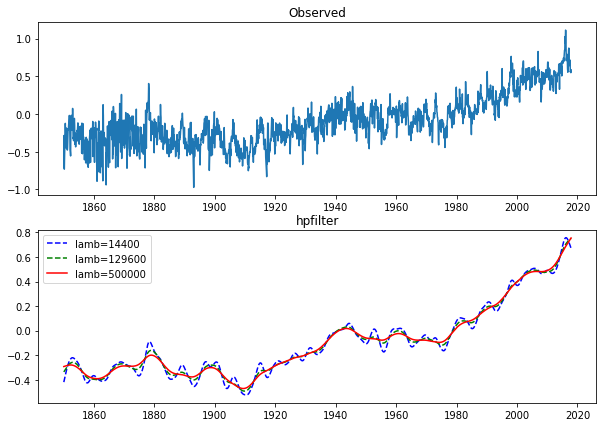

In [105]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt)
plt.title('Observed')
plt.subplot(2, 1, 2)
plt.plot(t, filter1, '--b')
plt.plot(t, filter2, '--g')
plt.plot(t, filter3, 'r')
plt.title('hpfilter')
plt.legend(['lamb=14400', 'lamb=129600', 'lamb=500000'])
plt.show()

### 例8.3 H-P滤波法处理英国人均GDP

本例题选取了gdp数据，并用H-P滤波进行处理。首先读取英国人均GDP数据：

In [106]:
data = pd.read_csv('data/gdp.csv')
t = np.arange(1270, 1914, 1)
y = data.iloc[:, 1]
xt = np.log(y)

分别对原数据和log对数处理过的数据进行H-P滤波，并计算年增长率

In [107]:
lamb = 10000
filter1 = hpfilter(xt, lamb)
filter2 = hpfilter(y, lamb)
annual = pd.DataFrame(filter2).pct_change()

将计算出数据画图，得到以下结果

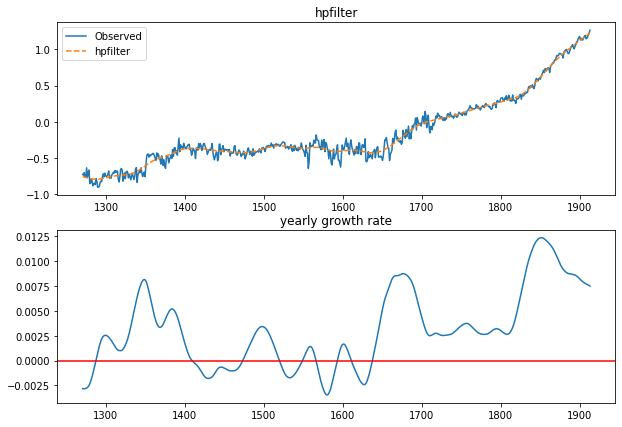

In [108]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt, t, filter1, '--')
plt.legend(['Observed', 'hpfilter'])
plt.title('hpfilter')
plt.subplot(2, 1, 2)
plt.plot(t[:], annual)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('yearly growth rate')
plt.show()

第一幅图为经过log处理过后的gdp数据，原数据与H-P滤波后的比较，第二幅图为H-P处理过的原数据的年增长率。

## 第九章 季节性与指数平滑

### 图9.1 英国季度啤酒销量一次差分的SACF值

首先我们先实现SACF部分的代码，这与前面所实现的大致相同：

In [109]:
def first_difference(xt):
    y = np.array([])
    for i in range(len(xt)-1):
        y = np.append(y, xt[i+1] - xt[i])
    return y


def autocorrelation_function(k, xt):
    mean = np.mean(xt)
    var = np.var(xt)
    temp = 0
    for i in range(k, len(xt)):
        temp += (xt[i] - mean)*(xt[i-k] - mean)
    r = temp/(len(xt)*var)
    return r

接着读取beer数据，用于计算SACF值

In [110]:
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

计算当前项值k从1至24时，对应SACF的值：

In [111]:
diff = first_difference(xt)
r = np.ones(24)
for k in range(1, 25):
    r[k-1] = autocorrelation_function(k, diff)

将数据以画图的形式展现：

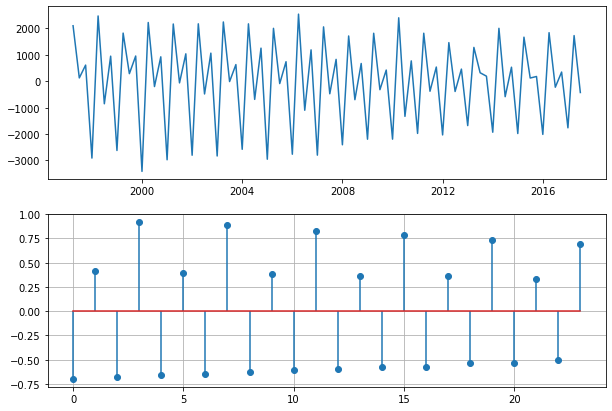

In [112]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t[1:], diff)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

第一幅图为一次差分后的原始数据，第二幅图为k值与SACF值的关系。

### 图9.2 英格兰和威尔士月降雨量平方根的SACF值

图9.2使用了rainfall数据，首先读取数据：

In [113]:
data = pd.read_csv('data/rainfall.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

计算当前项值k从1至48时，对应SACF的值：

In [114]:
xt = np.sqrt(xt)
r = np.ones(48)
for k in range(1, 49):
    r[k-1] = autocorrelation_function(k, xt)

将数据以画图的形式展现：

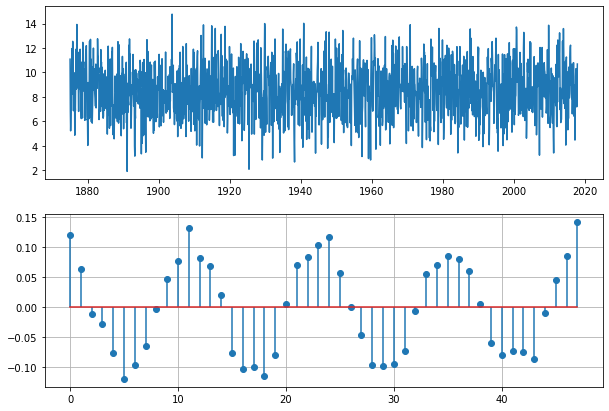

In [115]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

第一幅图为平方根后后的数据，第二幅图为k值与SACF值的关系。

### 例9.1 英格兰和威尔士降雨的确定性季节模型

本例题中，首先将数据进行次方转化（power transformations），再逐个月份提取数据的季节性特征。

首先运行次方转换函数：

In [116]:
def power_transformations(xt, lam):
    if lam == 0:
        return np.log(xt)
    else:
        return (np.power(xt, lam)-1)/lam

读取rainfall数据：

In [117]:
data = pd.read_csv('data/rainfall.csv')
temp = data.iloc[:, 0]
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = data.iloc[:, 1]

将数据进行次方转换，并分别计算12个月的均值

In [118]:
transform1 = power_transformations(xt, 0.7)
for j in range(12):
    locals()['rain'+str(temp[j][5:7])] = np.array([])
    meanlist = np.ones([1, 12])
for i in range(len(temp)):
    locals()['rain'+str(temp[i][5:7])] = np.append(locals()['rain'+str(temp[i][5:7])], transform1[i])
for j in range(12):
    meanlist[0][j] = np.mean(locals()['rain'+str(temp[j][5:7])])

将计算结果打印出来

In [119]:
meanlist = np.power(meanlist, 2)
print(meanlist)

[[ 951.3777867   616.10418091  597.47992825  525.84936653  587.14745725
   590.04491129  747.99771629  885.81024871  754.0871994  1072.93158257
  1092.62646744 1073.01702004]]


以上便是12个月降雨量的季节性特征

### 图9.3 啤酒销量各项差分的SACF

本图选取了beer数据，并隔四项进行差分，计算SACF。

首先读取beer数据：

In [120]:
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
xt = np.diff(data.iloc[:, 1])

对数据进行4项差分处理：

In [121]:
diff = np.ones(len(xt)-4)
for i in range(4, len(xt)):
    diff[i-4] = xt[i] - xt[i-4]

计算当前项值k从1至24时，对应SACF的值：

In [122]:
r = np.ones(24)
for k in range(1, 25):
    r[k-1] = autocorrelation_function(k, diff)

将数据以画图的形式展现：

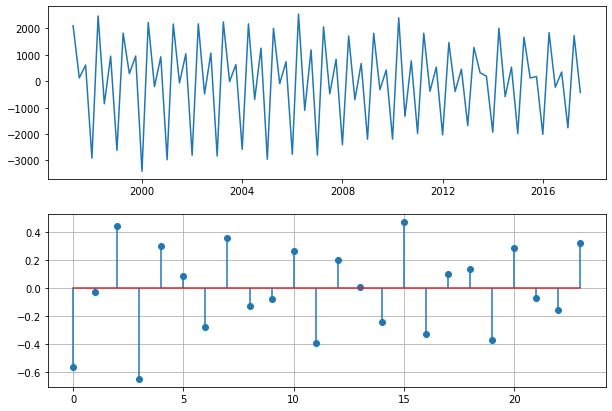

In [123]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t[1:], xt)
plt.subplot(2, 1, 2)
plt.grid(True)
plt.stem(r, use_line_collection=True)
plt.show()

### 例9.2 啤酒销量的季节性ARIMA模型

本题通过计算英国啤酒销量的季节性模型，对未来的数据进行预测。

首先，我们可以得到啤酒销量的ARIMA模型为：

$$
\nabla\nabla_4x_t=(1-0.694B)(1-0.604B^4)a_t=(1-0.694B-0.604B^4+0.419B^5)a_t \qquad \hat{\sigma}=271.9
$$

根据此模型，我们可以对啤酒销量进行季节性差分，并进一步通过模型进行拟合。

首先运行MA模型函数：

In [124]:
def moving_average(phi, sigma, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = a[i]
    for i in range(1, n):
        for t in range(k):
            if t == 0:
                temp = a[i]
            else:
                temp -= phi[t] * a[i - t]
        xt[i] = temp + const
    return xt

读取beer数据：

In [125]:
np.random.seed(20)
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
y = np.array(data.iloc[:, 1])
xt = np.diff(data.iloc[:, 1])

根据季节性模型，解出得到模型的数据：

In [126]:
ma = moving_average([0.694, 0, 0, 0.604, -0.419], 271.9, 0, len(xt)+9)
fdiff = np.ones(len(xt)+13)
fxt = np.ones(13)
fdiff[:4] = xt[:4]
for i in range(4, len(fdiff)):
    fdiff[i] = ma[i-4] + fdiff[i-4]
fxt[0] = y[-1]+fdiff[-13]
for j in range(1, 13):
    fxt[j] = fdiff[-13+j] + fxt[j-1]

将预测数据部分以画图形式体现：

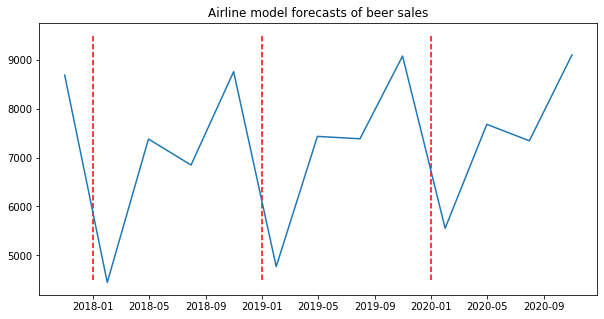

In [127]:
t = pd.date_range('2017-10-01', periods=13, freq='3M')
plt.figure(figsize=[10, 5])
plt.plot(t, fxt)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))
plt.vlines(x='2017-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.vlines(x='2018-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.vlines(x='2019-12-31', ymin=4500, ymax=9500, colors='r', linestyles='--')
plt.title('Airline model forecasts of beer sales')
plt.show()

### 例9.3 用指数平滑预测全球温度

回顾第八章的不可观测模型，观测到的数据是由白噪音和不可观测序列组成$x_t=z_t+u_t$ ，当时间序列无明显的趋势变化，可用**一次指数平滑**预测。此时$z_t$为：

$$
z_t=\alpha x_t+(1-\alpha)z_{t-1}
$$

将此公式（一次指数平滑）用代码实现，得到：

In [128]:
def single_exponential_smoothing(xt, alpha):
    zt = np.ones(len(xt))
    zt[0] = xt[0]
    for i in range(1, len(xt)):
        zt[i] = alpha*xt[i]+(1-alpha)*xt[i-1]
    return zt

**二次指数平滑**是指在一次指数平滑的基础上，加上了趋势$\tau_t$，使原式变为$x_t=z_t+u_t+\tau_t$，是一次指数平滑的再平滑。它适用于具线性趋势的时间序列。其预测公式为：
$$
z_t=\gamma x_t+(1-\gamma)z_{t-1} \\
\tau_t=\gamma(z_t-z_{t-1})+(1-\gamma)\tau_{t-1}
$$

将此公式（二次指数平滑）用代码实现，得到：

In [129]:
def double_exponential_smoothing(xt, gamma):
    zt = np.ones(len(xt))
    tao = np.ones(len(xt))
    zt[0], tao[0] = 0, 0
    zt[1] = gamma*xt[1]+(1-gamma)*zt[0]
    tao[1] = gamma*(zt[1]-zt[0])+(1-gamma)*tao[0]
    for i in range(2, len(xt)):
        zt[i] = gamma*xt[i]+(1-gamma)*zt[i-1]
        tao[i] = gamma * (zt[i] - zt[i-1]) + (1 - gamma) * tao[i-1]
    y = zt + tao
    return y

本题使用了global temps数据，分别用一次指数平滑与二次指数平滑对数据进行预测，并分别计算出RMSE的值，通过对RMSE的值的大小进行比对，从而判断哪一种预测方法效果更好。

首先读取global temps数据：

In [130]:
data = pd.read_csv('data/global_temps.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')[1:]
xt = np.diff(data.iloc[:, 1])

分别计算一次指数平滑$\lambda=0.45$时，二次指数平滑$\lambda=0.196$时的预测值：

In [131]:
ssmo = single_exponential_smoothing(xt, 0.45)
dsmo = double_exponential_smoothing(xt, 0.196)

分别计算RMSE的值，并将结果打印出来：

In [132]:
RMSE1 = np.sqrt(np.sum(np.power(xt[:]-ssmo[:], 2))/len(xt))
RMSE2 = np.sqrt(np.sum(np.power(xt[:]-dsmo[:], 2))/len(xt))
print(' single exp RMSE = ', RMSE1, '\n', 'double exp RMSE = ', RMSE2)

 single exp RMSE =  0.12555221411421877 
 double exp RMSE =  0.11876672136164598


将预测结果与原数据画图体现：

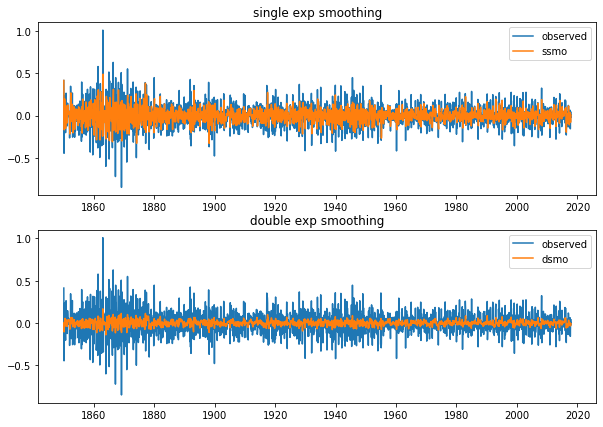

In [133]:
plt.figure(figsize=[10, 7])
plt.subplot(2, 1, 1)
plt.plot(t, xt, t, ssmo)
plt.legend(['observed', 'ssmo'])
plt.title('single exp smoothing')
plt.subplot(2, 1, 2)
plt.plot(t, xt, t, dsmo)
plt.legend(['observed', 'dsmo'])
plt.title('double exp smoothing')
plt.show()

### 例9.4 Holt-Winters模型预测啤酒销量数据

**三次指数平滑（Holt-Winters模型）**是在二次指数平滑的基础上，增加了季节分量$s_t$，使原式变为$x_t=z_t+s_t+\tau_t$。

Holt-Winters模型分为加法模型和乘法模型，加法模型的预测公式为：

$$
z_t=\alpha(x_t-s_{t-m})+(1-\beta)(z_{t-1}+\tau_{t-1}) \\
\tau_t=\beta(z_t-z_{t-1})+(1-\beta)\tau_{t-1} \\
s_t=\delta(x_t-z_t)+(1-\delta)s_{t-m}
$$

乘法模型的预测公式为：

$$
z_t=\alpha(\frac{x_t}{s_{t-m}})+(1-\beta)(z_{t-1}+\tau_{t-1}) \\
\tau_t=\beta(z_t-z_{t-1})+(1-\beta)\tau_{t-1} \\
s_t=\delta(\frac{x_t}{z_t})+(1-\delta)s_{t-m}
$$

接下来，分别用代码对加法模型和乘法模型进行实现：

In [134]:
def returndiff(x0, diff):
    xt = np.ones(len(diff)+1)
    xt[0] = x0
    for i in range(1, len(xt)):
        xt[i] = diff[i-1]+xt[i-1]
    return xt


def add_holt(xt, alpha, beta, delta, m, h):
    n = len(xt)
    zt, tao, st = [np.ones(n+h) for _ in range(3)]
    zt[0], tao[0] = xt[0], xt[0]
    st[-m:m] = 0
    for i in range(1, n):
        zt[i] = alpha*(xt[i]-st[i-m])+(1-beta)*(zt[i-1]+tao[i-1])
        tao[i] = beta*(zt[i]-zt[i-1])+(1-beta)*tao[i-1]
        st[i] = delta*(xt[i]-zt[i])+(1-delta)*st[i-m]
    for j in range(h):
        zt[n+j] = (1-beta)*(zt[j-1]+tao[j-1])
        tao[n+j] = beta*(zt[n+j]-zt[n+j-1])+(1-beta)*tao[n+j-1]
        st[n+j] = (1-delta)*st[n+j-m]
    y = zt+st+tao
    return y


def mul_holt(xt, alpha, beta, delta, m, h):
    n = len(xt)
    zt, tao, st = [np.ones(n+h) for _ in range(3)]
    zt[0], tao[0] = xt[0], 0
    st[-m:m] = delta
    for i in range(1, n):
        zt[i] = alpha*(xt[i]/st[i-m])+(1-beta)*(zt[i-1]+tao[i-1])
        tao[i] = beta*(zt[i]-zt[i-1])+(1-beta)*tao[i-1]
        st[i] = delta*(xt[i]/zt[i])+(1-delta)*st[i-m]
    for j in range(h):
        zt[n+j] = (1-beta)*(zt[j-1]+tao[j-1])
        tao[n+j] = beta*(zt[n+j]-zt[n+j-1])+(1-beta)*tao[n+j-1]
        st[n+j] = (1-delta)*st[n+j-m]
    y = zt*st+tao
    return y

使用beer数据，用两种方法分别进行预测。首先读取beer数据：

In [135]:
np.random.seed(2)
data = pd.read_csv('data/beer.csv')
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
y = data.iloc[:, 1]
xt = np.diff(data.iloc[:, 1])

分别用两种方法，对未来的数据进行预测：

In [136]:
h = 13
addho = add_holt(xt, 0.1, 0.79, 0.33, 4, h)
mulho = mul_holt(xt, 0.1, 0.81, 0, 4, h)
addho = returndiff(y[0], addho)
mulho = returndiff(y[0], mulho)

将原数据、模型预测数据、未来数据预测画图展现，得到：

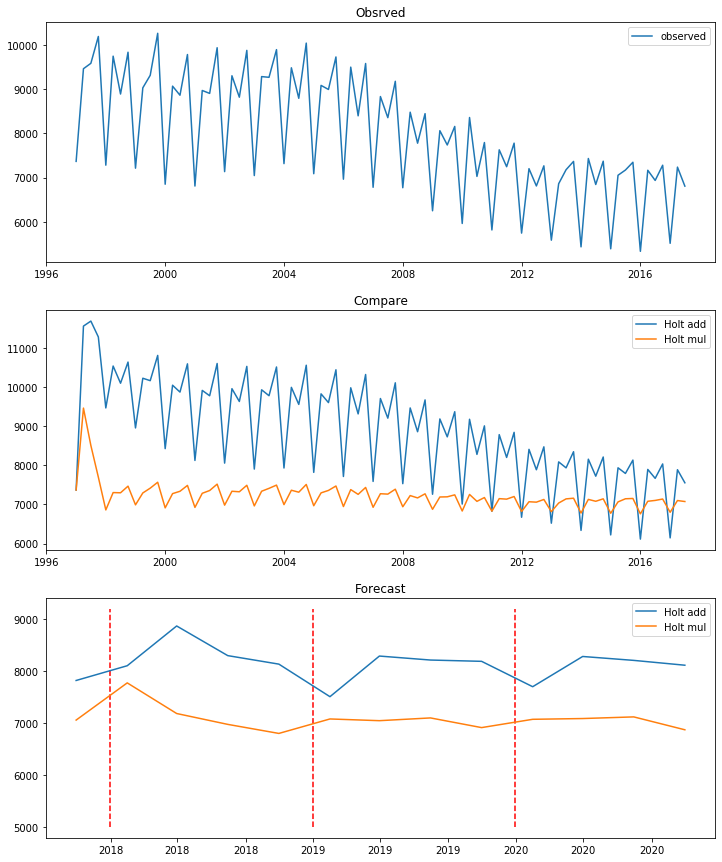

In [137]:
tt = pd.date_range('2017-10-01', periods=13, freq='3M')
plt.figure(figsize=[12, 15])
plt.subplot(3, 1, 1)
plt.plot(t, y)
plt.legend(['observed'])
plt.title('Obsrved')
plt.subplot(3, 1, 2)
plt.plot(t, addho[:-h], t, mulho[:-h])
plt.legend(['Holt add', 'Holt mul'])
plt.title('Compare')
plt.subplot(3, 1, 3)
plt.plot(tt, addho[-13:], tt, mulho[-13:])
plt.legend(['Holt add', 'Holt mul'])
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y'))
plt.vlines(x='2017-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.vlines(x='2018-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.vlines(x='2019-12-31', ymin=5000, ymax=9200, colors='r', linestyles='--')
plt.title('Forecast')
plt.show()

## 第十章 ARCH&GARCH

### **自回归条件异方差模型(ARCH)**

#### 波动率的特征

对于金融时间序列，波动率往往具有以下特征：

（1）存在**波动率聚集**现象。 即波动率在一段时间上高，一段时间上低。

（2）波动率以连续时间变化，很少发生跳跃

（3）波动率不会发散到无穷，波动率往往是**平稳**的

（4）波动率对价格大幅上升和大幅下降的反应是不同的，这个现象为**杠杆效应**



#### ARCH的基本原理

在传统计量经济学模型中，干扰项的方差被假设为常数。但是许多经济时间序列呈现出波动的集聚性，在这种情况下假设方差为常数是不恰当的。

ARCH模型将当前一切可利用信息作为条件，并采用某种自回归形式来刻划方差的变异，对于一个时间序列而言，在不同时刻可利用的信息不同，而相应的条件方差也不同，利用ARCH 模型，可以刻划出随时间而变异的条件方差。



#### ARCH模型思想

1. 资产收益率序列的扰动 {$a_t$} 是序列不相关的，但是不独立。

2. {$a_t$}的不独立性可以用其延迟值的简单二次函数来描述。具体而言，一个ARCH(m)模型为：

$a_{t}=\sigma_{t} \varepsilon_{t} \sigma_{t}^{2}=\alpha_{0}+\alpha_{1} a_{t-1}^{2}+\cdots+\alpha_{m} a_{t-m}^{2} \alpha_{0}>0 ; \forall i>0, \alpha_{i} \geqslant 0$

其中，{$\epsilon_t$}为 **均值为0，方差为1的独立同分布（iid）随机变量序列。**通常假定其服从标准正态分布。$\sigma^2$为条件异方差。



#### ARCH模型效应

从上面模型的结构看，大的过去的平方“扰动”会导致信息*$a_t$*大的条件异方差。从而at有取绝对值较大的值的倾向。这意味着：**在ARCH的框架下，大的"扰动"会倾向于紧接着出现另一个大的"扰动"。这与波动率聚集的现象相似。**

所谓ARCH模型效应，也就是**条件异方差序列的序列相关性**



### 例1：以沪深300指数为例，考察其收益率时间的分布和统计特性。

In [138]:
import tushare as ts
#tsa为Time Series analysis缩写


#画图
# 
#正常显示画图时出现的中文和负号

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# 定义画图函数
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0))
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags,
              ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags,
             ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')
        scs.probplot(data, sparams=(data.mean(),
          data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图')
        plt.tight_layout()
    return

**ARCH模型的建模步骤：**

1. 检验收益序列是否平稳，根据自相关性建立合适的均值方程，如ARMA模型，描述收益率如何随时间变化，根据拟合的模型和实际值，得到残差序列。
2. 对拟合的均值方程得到的残差序列进行ARCH效应检验，即检验收益率围绕均值的偏差是否时大时小。检验序列是否具有ARCH效应的方法有两种：Ljung-Box检验和LM检验。
3. 若ARCH效应在统计上显著，则需要再设定一个波动率模型来刻画波动率的动态变化。
4. 对均值方差和波动率方差进行联合估计，即假设实际数据服从前面设定的均值方差和波动率方差后，对均值方差和波动率方差中的参数进行估计，并得到估计的误差。
5. 对拟合的模型进行检验。如果估计结果（残差项）不满足模型本身的假设，则模型的可用性较差。

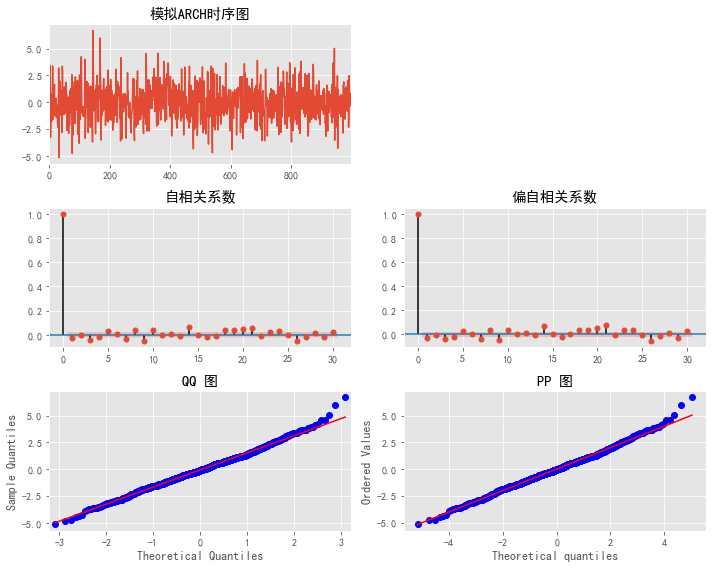

In [139]:
# 模拟ARCH时间序列，对沪深300收益率的ARCH效应进行统计检验
np.random.seed(2)
a0 = 2
a1 = .5
y = w = np.random.normal(size=1000)
Y = np.empty_like(y)
for t in range(1,len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
ts_plot(Y, lags=30,title='模拟ARCH')

def ret_plot(ts, title=''):
    ts1=ts**2
    ts2=np.abs(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(12, 6))
        layout = (2, 1)
        ts1_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        ts2_ax = plt.subplot2grid(layout, (1, 0))
        ts1.plot(ax=ts1_ax)
        ts1_ax.set_title(title+'日收益率平方')
        ts2.plot(ax=ts2_ax)
        ts2_ax.set_title(title+'日收益率绝对值')
        plt.tight_layout()
    return

# 使用Ljung-Box统计量对收益率平方的自相关性进行统计检验
def whitenoise_test(ts):
    '''计算box pierce 和 box ljung统计量'''
    from statsmodels.stats.diagnostic import acorr_ljungbox
    q,p=acorr_ljungbox(ts)
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 4))
        axes = fig.subplots(1,2)
        axes[0].plot(q, label='Q统计量')
        axes[0].set_ylabel('Q')
        axes[1].plot(p, label='p值')
        axes[1].set_ylabel('P')
        axes[0].legend()
        axes[1].legend()
        plt.tight_layout()
    return

### **GARCH模型与波动率预测**

虽然ARCH模型简单，但为了充分刻画收益率的波动率过程，往往需要很多参数，例如上面用到ARCH(4)模型，有时会有更高的ARCH(m)模型。因此，Bollerslev(1986)年提出了一个推广形式，称为**广义的ARCH模型（GARCH）**。另$a_{t}=r_{t}-\mu_{t}$，为t时刻的信息。若at满足下式：

$a_{t}=\sigma_{t} \varepsilon_{t} \sigma_{t}^{2}=\alpha_{0}+\sum_{i=1}^{m} \alpha_{i} a_{t-i}^{2}+\sum_{j=1}^{s} \beta_{j} \sigma_{t-j}^{2} \alpha_{0}>0 ; \forall i>0, \alpha_{i} \geqslant 0, \beta_{i} \geqslant 0,\left(\alpha_{i}+\beta_{i}\right)<1$

其中，$\varepsilon_{t}$为**均值为0，方差为1的独立同分布（iid）随机变量序列**。通常假定其服从**标准正态分布**或**标准化学生-t分布**。$\sigma_{t}^{2}$为条件异方差。则称$a_{t}$服从GARCH(m,s)模型。

#### GARCH模型建立

与之前的ARCH模型建立过程类似，不过GARCH(m,s)的定阶较难，一般使用低阶模型如GARCH(1,1),GARCH(2,1),GARCH(1,2)等。实际应用中，GARCH(1,1)和GARCH(2,1)一般可以满足对自回归条件异方差的描述。下面使用Python对GARCH(1,1)模型进行模拟和估计

### 例2：模拟GARCH（1,1）过程

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12199.134540521049
            Iterations: 14
            Function evaluations: 94
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12199.1
Distribution:                  Normal   AIC:                           24406.3
Method:            Maximum Likelihood   BIC:                           24435.1
                                        No. Observations:                10000
Date:                Sat, Aug 15 2020   Df Residuals:                     9996
Time:                        16:37:05   Df Model:                            4
                                  Mean Model                                  

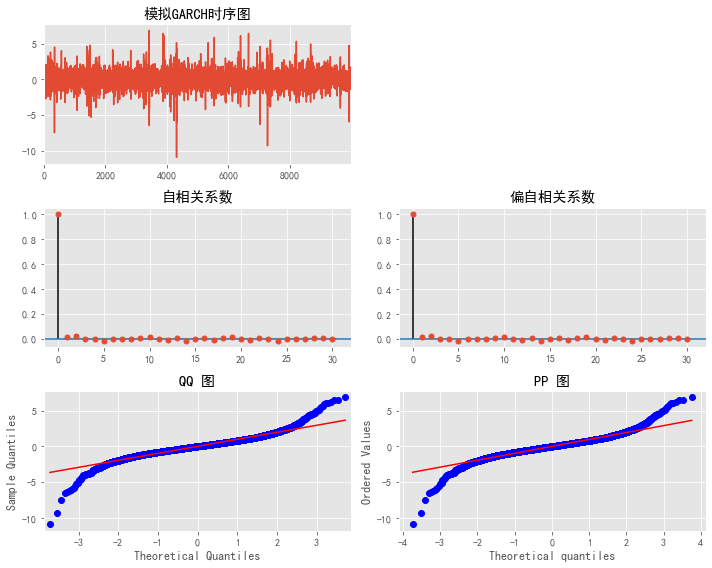

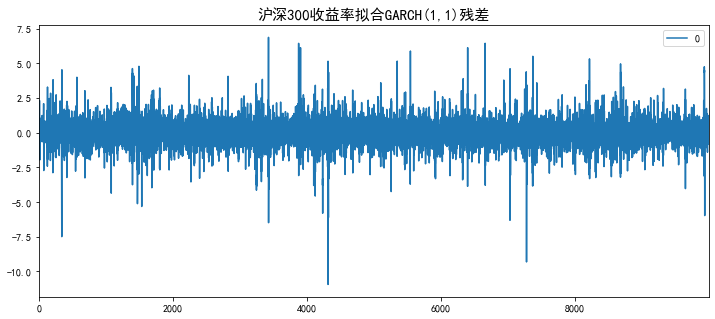

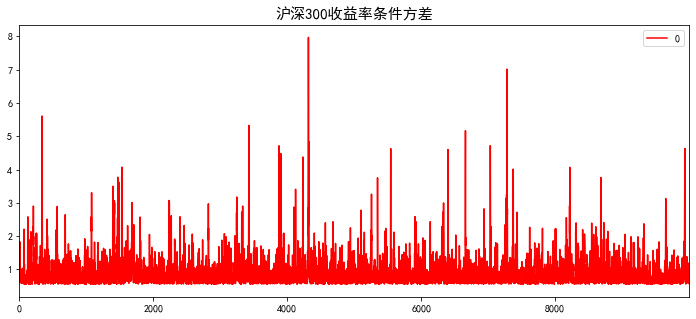

In [140]:
# 模拟GARCH(1, 1) 过程
np.random.seed(1)
a0 = 0.2
a1 = 0.5
b1 = 0.3
n = 10000
w = np.random.normal(size=n)
garch = np.zeros_like(w)
sigsq = np.zeros_like(w)
for i in range(1, n):
    sigsq[i] = a0 + a1*(garch[i-1]**2) + b1*sigsq[i-1]
    garch[i] = w[i] * np.sqrt(sigsq[i])
_ = ts_plot(garch, lags=30,title='模拟GARCH')
# 使用模拟的数据进行 GARCH(1, 1) 模型拟合
#arch_model默认建立GARCH（1,1）模型
am = arch_model(garch)
res = am.fit(update_freq=0)
print(res.summary())

pd.DataFrame(res.resid).plot(figsize=(12,5))
plt.title('沪深300收益率拟合GARCH(1,1)残差',size=15)
plt.show()
pd.DataFrame(res.conditional_volatility).plot(figsize=(12,5),color='r')
plt.title('沪深300收益率条件方差',size=15)
plt.show()


## 第十一章 非线性随机过程

### 双线性模型（Bilinear Model）

称随机序列$\left\{x_{i}\right\}$ 服从双线性模型，如果：

$x_{i}=\sum_{j=1}^{p} \varphi_{j} x_{i-j}+\sum_{j=0}^{q} \theta_{j} a_{i-j}+\sum_{k=0}^{Q} \sum_{l=1}^{P} \beta_{k l} x_{i-l} a_{i-k}$

其中$a_{i}$为i.i.d.随机序列，$E a_{i}=0, E a_{i}^{2}=\sigma^{2}$，当$\beta_{k l}=0(k=0,1, \ldots, Q, l=1, \ldots, P)$

则(1)式成为ARMA（p，q）模型，因此双线性模型是线性模型的直接推广。

### 门限平滑移动自回归模型（Threshold and Smooth Transition Autoregressions）

门限自回归模型(threshold autoregressive model)，又称阈模型，简称TAR模型，它是一种非线性模型。门限自回归模型的模型形式与分段线性模型形式非常相似。门限或阈（Threshold）的概念是指高于或低于门限值（阈值）的自回归过程不同，因此，可以捕捉到一个过程下降和上升模式中的非对称性。

#### 思路及定义

TAR的基本思路：在观测时序$\left\{x_{i}\right\}$ 的取值范围内引入L-1个门限值$r_{j}=(j=1,2, \ldots, L-1)$ ，将该范围分成 L个区间，并根据延迟步数d将$\left\{x_{i}\right\}$按$\left\{x_{i-d}\right\}$值的大小分配到不同的门限区间内，再对不同区间内的$x_{i}$采用不同的自回归模型来描述，这些自回归模型的总和完成了对时序$\left\{x_{i}\right\}$整个非线性动态系统的描述。其一般形式为：

$x_{i}=\sum_{i=1}^{n_{j}} \varphi_{i}^{(j)} \alpha_{i}^{(j)}, r_{j-1}<x_{i-d} \leq r_{j}, j=1,2, \ldots, L$

其中，$r_{j}=(j=1,2, \ldots, L-1)$为门限值，L为门限期间的个数；d为延迟步数；$\left\{\alpha_{t}^{(j)}\right\}$对每一固定的j是方差为$\sigma_{t}^{2}$的白噪声系列，各$\left\{\alpha_{t}^{(j)}\right\}(j=1,2, \ldots, L-1)$之间是相互独立的；$\varphi^{(j)}$为第j个门限区间自回归系数；$n_{j}$为第j个门限区间模型的阶数。由于TAR模型实质是分区间的AR模型，建模时沿用AR模型的参数估计方法和模型检验准则，如最小二乘法与AIC准则。其建模过程实质上是一个对d，L，$r_{j}(j=1,2, \ldots, L-1), n_{j}(j=1,2, \ldots, L-1)$和$\varphi^{(j)}(j=1,2, \ldots, L-1)$ 的多维寻优问题。

#### 建模步骤

1. 确实门限变量
2. 确定率定门限数L
3. 确定门限值
4. 确定回归系数的过程

为了计算方便，这里采用二分割（即L=2）说明模型的建模步骤。

### 例1：

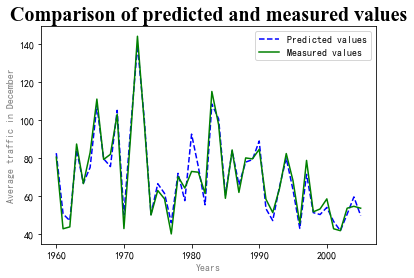

In [141]:
from sklearn.linear_model import LinearRegression
# 利用pandas读取csv，读取的数据为DataFrame对象
data = pd.read_csv('data/jl.csv')
# 将DataFrame对象转化为数组,数组的第一列为数据序号，最后一列为预报对象，中间各列为预报因子
data= data.values.copy()
# print(data)
# 计算互相关系数，参数为预报因子序列和滞时k
def get_regre_coef(X,Y,k):
    S_xy=0
    S_xx=0
    S_yy=0
    # 计算预报因子和预报对象的均值
    X_mean = np.mean(X)
    Y_mean = np.mean(Y)
    for i in  range(len(X)-k):
        S_xy += (X[i] - X_mean) * (Y[i+k] - Y_mean)
    for i in range(len(X)):
        S_xx += pow(X[i] - X_mean, 2)
        S_yy += pow(Y[i] - Y_mean, 2)
    return S_xy/pow(S_xx*S_yy,0.5)
#计算相关系数矩阵
def regre_coef_matrix(data):
    row=data.shape[1]#列数
    r_matrix=np.ones((1,row-2))
    # print(row)
    for i in range(1,row-1):
        r_matrix[0,i-1]=get_regre_coef(data[:,i],data[:,row-1],1)#滞时为1
    return r_matrix
r_matrix=regre_coef_matrix(data)
# print(r_matrix)
###输出###
#[[0.048979   0.07829989 0.19005705 0.27501209 0.28604638]]

#对相关系数进行排序找到相关系数最大者作为门限元
def get_menxiannum(r_matrix):
    row=r_matrix.shape[1]#列数
    for i in range(row):
        if r_matrix.max()==r_matrix[0,i]:
            return i+1
    return -1
m=get_menxiannum(r_matrix)
# print(m)
##输出##第五个因子的互相关系数最大

#根据门限元对因子序列进行排序,m为门限变量的序号
def resort_bymenxian(data,m):
    data=data.tolist()#转化为列表
    data.sort(key=lambda x: x[m])#列表按照m+1列进行排序(升序)
    data=np.array(data)
    return data
data=resort_bymenxian(data,m)#得到排序后的序列数组

# 将排序后的序列按照门限元分割序列为两段，第一分割第一段1个数据，第二段n-1（n为样本容量）个数据；第二次分割第一段2个数据，第二段n-2个数据，一次类推，分别计算出分割后的F统计量并选出最大统计量对应的门限元的分割点作为门限值
def get_var(x):
    return x.std() ** 2 * x.size  # 计算总方差
#统计量F的计算,输入数据为按照门限元排序后的预报对象数据
def get_F(Y):
    col=Y.shape[0]#行数，样本容量
    FF=np.ones((1,col-1))#存储不同分割点的统计量
    V=get_var(Y)#计算总方差
    for i in range(1,col):#1到col-1
        S=get_var(Y[0:i])+get_var(Y[i:col])#计算两段的组内方差和
        F=(V-S)*(col-2)/S
        FF[0,i-1]=F#此步需要判断是否通过F检验，通过了才保留F统计量
    return FF
y=data[:,data.shape[1]-1]
FF=get_F(y)
def get_index(FF,element):#获取element在一维数组FF中第一次出现的索引
    i=-1
    for item in FF.flat:
        i+=1
        if item==element:
            return i
f_index=get_index(FF,np.max(FF))#获取统计量F的最大索引
# print(data[f_index,m-1])#门限元为第五个因子，代入索引得门限值 121

# 以门限值为分割点将数据序列分割为两段，分别进行多元线性回归，此处利用sklearn.linear_model模块中的线性回归模块。再代入预报因子分别计算两段的预测值
#以门限值为分割点将新data序列分为两部分，分别进行多元回归计算
def data_excision(data,f_index):
    f_index=f_index+1
    data1=data[0:f_index,:]
    data2=data[f_index:data.shape[0],:]
    return data1,data2
data1,data2=data_excision(data,f_index)
# 第一段
def get_XY(data):
    # 数组切片对变量进行赋值
    Y = data[:, data.shape[1] - 1]  # 预报对象位于最后一列
    X = data[:, 1:data.shape[1] - 1]#预报因子从第二列到倒数第二列
    return X, Y
X,Y=get_XY(data1)
regs=LinearRegression()
regs.fit(X,Y)
# print('第一段')
# print(regs.coef_)#输出回归系数
# print(regs.score(X,Y))#输出相关系数
#计算预测值
Y1=regs.predict(X)
# print('第二段')
X,Y=get_XY(data2)
regs.fit(X,Y)
# print(regs.coef_)#输出回归系数
# print(regs.score(X,Y))#输出相关系数
#计算预测值
Y2=regs.predict(X)
Y=np.column_stack((data[:,0],np.hstack((Y1,Y2)))).copy()
Y=np.column_stack((Y,data[:,data.shape[1]-1]))
Y=resort_bymenxian(Y,0)

# 将预测值和实际值按照年份序号从新排序，恢复其顺序，利用matplotlib模块做出预测值与实际值得对比图
#恢复顺序
Y=resort_bymenxian(Y,0)
# print(Y.shape)
# 预测结果可视化
plt.plot(Y[:,0],Y[:,1],'b--',Y[:,0],Y[:,2],'g')
plt.title('Comparison of predicted and measured values',fontsize=20,fontname='Times New Roman')#添加标题
plt.xlabel('Years',color='gray')#添加x轴标签
plt.ylabel('Average traffic in December',color='gray')#添加y轴标签
plt.legend(['Predicted values','Measured values'])#添加图例
plt.show()

### 马尔可夫转换模型（Markov Switching Model）

时间序列建模的最简单方法是线性自回归模型。自回归模型指定输出变量线性地取决于其自身的先前值和随机项，即假定时间序列的均值和方差在所考虑的整个时间段内保持不变，但现实数据往往很难满足这样的条件。由于某些结构上的变化，时间序列可以从一个时期到下一个时期完全改变。区制转移模型（Regime shift models，简称RSM）通过将时间序列分为不同的“状态”，来解决基本时间序列建模中的不足。


#### 基本思路

 时间序列存在于两个或多个状态，每个状态都有自己的概率分布，并且一个状态到另一个状态的转换由另一个过程或变量控制。区制转移模型有三种类型：阈值模型（Threshold models）、预测模型（Predictive models）和马尔科夫转换自回归模型（Markov switching autoregressive models）。

阈值模型观察到的变量超过阈值会触发状态转换。马尔科夫转换自回归模型（MSAM），假定状态为“隐藏状态”，并假定潜在状态的的转换遵循同质一阶马尔可夫链，而下一个状态的概率仅取决于当前状态。可以通过最大似然法来估计从一个状态到下一个状态的转移概率，通过使似然函数最大化来估计参数值。

### 例2：对上证综指的周收益率时间序列进行建模分析

In [142]:
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
df=ts.get_k_data('sh',start='2000-01-01',end='2020-06-16')
df.index=pd.to_datetime(df.date)
df.head()

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


,date,open,close,high,low,volume,code
date,,,,,,,
2000-01-04,2000-01-04,1368.69,1406.37,1407.52,1361.21,9034020.0,sh
2000-01-05,2000-01-05,1407.83,1409.68,1433.78,1398.32,10580000.0,sh
2000-01-06,2000-01-06,1406.04,1463.94,1463.95,1400.25,13480500.0,sh
2000-01-07,2000-01-07,1477.15,1516.60,1522.82,1477.15,34515700.0,sh
2000-01-10,2000-01-10,1531.71,1545.11,1546.72,1506.40,31253500.0,sh


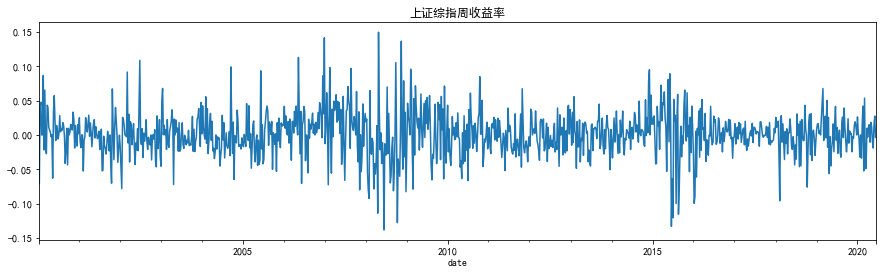

In [143]:
#上证综指周收益率
df_ret=df.close.resample('W').last().pct_change().dropna()
df_ret.plot(title='上证综指周收益率',figsize=(15,4))
plt.show()

**平稳性检验**

In [144]:
#使用arch包中的单位根检验unitroot导入ADF
from arch.unitroot import ADF
ADF(df_ret)

#模型拟合
mod = sm.tsa.MarkovRegression(df_ret.dropna(), 
k_regimes=3, trend='nc', switching_variance=True)
 
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  close   No. Observations:                 1067
Model:               MarkovRegression   Log Likelihood                2262.191
Date:                Sat, 15 Aug 2020   AIC                          -4506.382
Time:                        16:37:10   BIC                          -4461.628
Sample:                    01-16-2000   HQIC                         -4489.426
                         - 06-21-2020                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   4.07e-05      8.235      0.000       0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012      0.000      9.557      0.000       0.001       0.001
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0027      0.000      5.334      0.000       0.002       0.004
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9370      0.022     42.312      0.000       0.894       0.980
p[1->0]        0.1029      0.052      1.965      0.049       0.000       0.206
p[2->0]     6.929e-74      0.068   1.03e-72      1.000      -0.132       0.132
p[0->1]        0.0604      0.007      8.350      0.000       0.046       0.075
p[1->1]        0.8925      0.025     36.046      0.000       0.844       0.941
p[2->1]        0.0127      0.042      0.300      0.764      -0.070       0.096
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

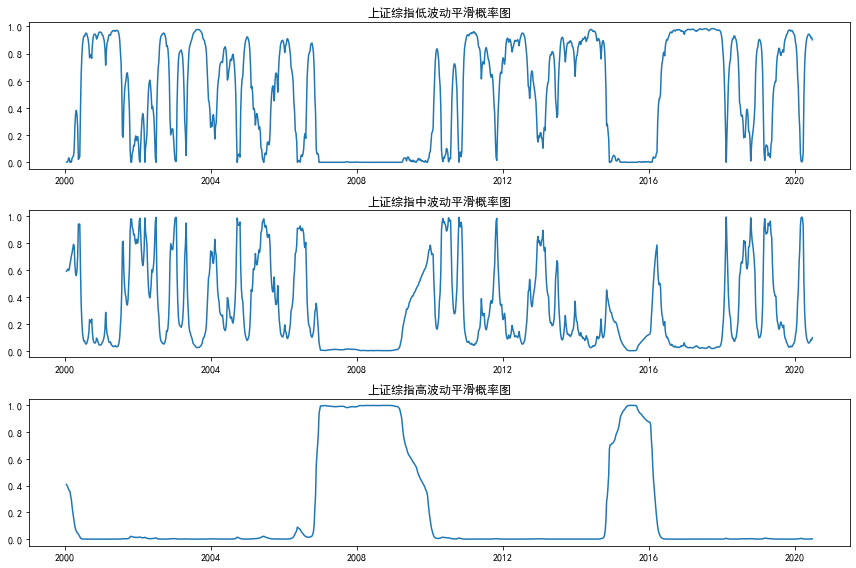

In [145]:
fig, axes = plt.subplots(3, figsize=(12,8))
ax = axes[0]
ax.plot(res.smoothed_marginal_probabilities[0])
ax.set(title='上证综指低波动平滑概率图')
ax = axes[1]
ax.plot(res.smoothed_marginal_probabilities[1])
ax.set(title='上证综指中波动平滑概率图')
ax = axes[2]
ax.plot(res.smoothed_marginal_probabilities[2])
ax.set(title='上证综指高波动平滑概率图')
fig.tight_layout()

**具体情况**

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


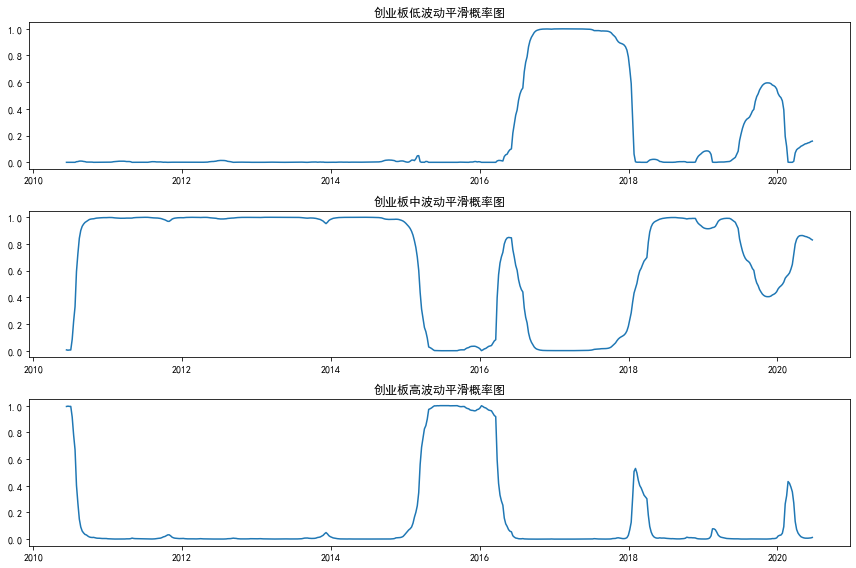

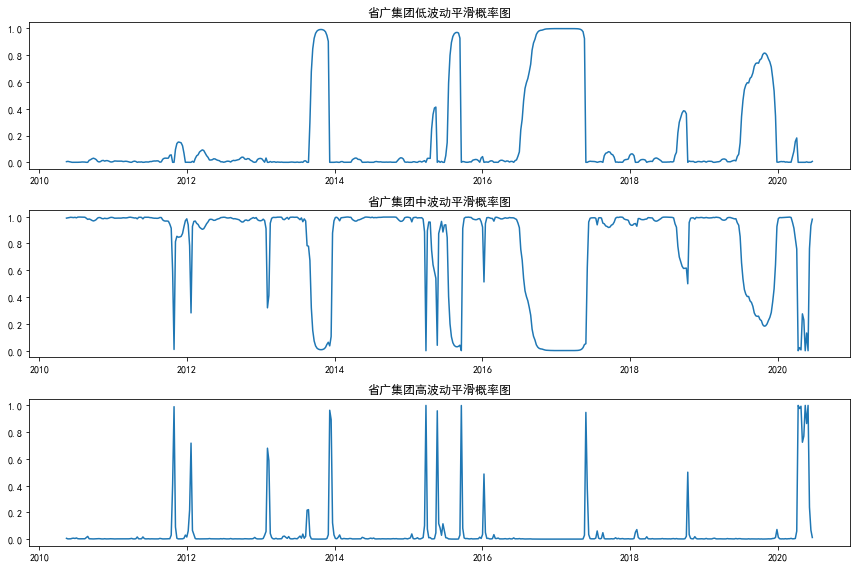

In [146]:
# 为了分析更多的指数或个股，下面将上述分析过程使用函数表示
def plot_rsm(code,title,start='2010-01-01',end='2020-06-17'):
    df=ts.get_k_data(code,start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df_ret=df.close.resample('w').last().pct_change().dropna()
    #模型拟合
    mod = sm.tsa.MarkovRegression(df_ret.dropna(), k_regimes=3, trend='nc', switching_variance=True)
    res = mod.fit()
    fig, axes = plt.subplots(3, figsize=(12,8))
    ax = axes[0]
    ax.plot(res.smoothed_marginal_probabilities[0])
    ax.set(title=title+'低波动平滑概率图')
    ax = axes[1]
    ax.plot(res.smoothed_marginal_probabilities[1])
    ax.set(title=title+'中波动平滑概率图')
    ax = axes[2]
    ax.plot(res.smoothed_marginal_probabilities[2])
    ax.set(title=title+'高波动平滑概率图')
    fig.tight_layout()
    
plot_rsm('cyb','创业板')
plot_rsm('002400','省广集团')

### 非线性检测（BDS Test）

但是一个变量到底应该建立线性模型还是应该建立非线性模型，需要有相应的检验标准来判断序列的性质。

它们可以大致分成两类：一类是混合检验，另一类检验是针对某些特定的备择假设模型所设计的。

（1）混合检验，即没有指定的备择假设模型，主要是检验对线性模型的偏离。关于混合检验，早期的有Ramsey (1969)提出的基于拉格朗日乘子原理的RESET检验、McLeod和Li (1983)关于模型残差ARCH效应的检验以及Broock和Scheinkman等(1996)提出的检验残差独立性的**BDS检验**。

（2）针对某些特定的备择假设模型所设计的检验。关于这类检验，备择假设模型可以是平滑转移自回归模型((STAR)或门限自回归模型(TAR)等。例如，Terasvirta (1994)研究了用Taylor展开式对LSTAR和ESTAR模型效应进行检验的方法。

### 例3：bds检验函数

In [147]:
def distance_indicators(x, epsilon=None, distance=1.5):
    x = array_like(x, 'x')

    if epsilon is not None and epsilon <= 0:
        raise ValueError("Threshold distance must be positive if specified."
                         " Got epsilon of %f" % epsilon)
    if distance <= 0:
        raise ValueError("Threshold distance must be positive."
                         " Got distance multiplier %f" % distance)
    if epsilon is None:
        epsilon = distance * x.std(ddof=1)

    return np.abs(x[:, None] - x) < epsilon


def correlation_sum(indicators, embedding_dim):
    if not indicators.ndim == 2:
        raise ValueError('Indicators must be a matrix')
    if not indicators.shape[0] == indicators.shape[1]:
        raise ValueError('Indicator matrix must be symmetric (square)')

    if embedding_dim == 1:
        indicators_joint = indicators
    else:
        corrsum, indicators = correlation_sum(indicators, embedding_dim - 1)
        indicators_joint = indicators[1:, 1:]*indicators[:-1, :-1]

    nobs = len(indicators_joint)
    corrsum = np.mean(indicators_joint[np.triu_indices(nobs, 1)])
    return corrsum, indicators_joint


def correlation_sums(indicators, max_dim):
    corrsums = np.zeros((1, max_dim))

    corrsums[0, 0], indicators = correlation_sum(indicators, 1)
    for i in range(1, max_dim):
        corrsums[0, i], indicators = correlation_sum(indicators, 2)

    return corrsums

def _var(indicators, max_dim):
   
    nobs = len(indicators)
    corrsum_1dim, _ = correlation_sum(indicators, 1)
    k = ((indicators.sum(1)**2).sum() - 3*indicators.sum() +
         2*nobs) / (nobs * (nobs - 1) * (nobs - 2))

    variances = np.zeros((1, max_dim - 1))

    for embedding_dim in range(2, max_dim + 1):
        tmp = 0
        for j in range(1, embedding_dim):
            tmp += (k**(embedding_dim - j))*(corrsum_1dim**(2 * j))
        variances[0, embedding_dim-2] = 4 * (
            k**embedding_dim +
            2 * tmp +
            ((embedding_dim - 1)**2) * (corrsum_1dim**(2 * embedding_dim)) -
            (embedding_dim**2) * k * (corrsum_1dim**(2 * embedding_dim - 2)))

    return variances, k

# 定义bds函数，非线性检验
def bds(x, max_dim=2, epsilon=None, distance=1.5):
    x = array_like(x, 'x', ndim=1)
    nobs_full = len(x)

    if max_dim < 2 or max_dim >= nobs_full:
        raise ValueError("Maximum embedding dimension must be in the range"
                         " [2,len(x)-1]. Got %d." % max_dim)

    indicators = distance_indicators(x, epsilon, distance)
    corrsum_mdims = correlation_sums(indicators, max_dim)

    variances, k = _var(indicators, max_dim)
    stddevs = np.sqrt(variances)

    bds_stats = np.zeros((1, max_dim - 1))
    pvalues = np.zeros((1, max_dim - 1))
    for embedding_dim in range(2, max_dim+1):
        ninitial = (embedding_dim - 1)
        nobs = nobs_full - ninitial

        corrsum_1dim, _ = correlation_sum(indicators[ninitial:, ninitial:], 1)
        corrsum_mdim = corrsum_mdims[0, embedding_dim - 1]

        effect = corrsum_mdim - (corrsum_1dim**embedding_dim)
        sd = stddevs[0, embedding_dim - 2]

        bds_stats[0, embedding_dim - 2] = np.sqrt(nobs) * effect / sd

        pvalue = 2*stats.norm.sf(np.abs(bds_stats[0, embedding_dim - 2]))
        pvalues[0, embedding_dim - 2] = pvalue

    return np.squeeze(bds_stats), np.squeeze(pvalues)

## 第十二章 传递函数和自回归分布滞后模型

### 单输入传递函数噪声模型

​	此模型中，内生变量（输出）与单个外生变量（输入）相关：
$$
y_t = v(B)x_t + n_t
$$
其中，滞后多项式$v(B) = v_0 + v_1B + v_2B^2 + ……$作为传递函数，允许x通过分布滞后影响y。此模型一关键假设为$x_t$与$n_t$独立，即过去的x会影响y，但y的变化不能反馈到x。

​	由于v(B)的阶数无限，我们需要加一些限制使其变得可行。于是把v(B)写为合理的滞后公式$v(B) = \frac{w(B)B^b}{\delta(B)}$，其中$w(B) = w_0 - w_1B - … - w_sB^s$，$\delta(B) = 1 - \delta_1B - … - \delta_rB^r$。若噪声遵循ARMA(p, q)模型:$n_t = \frac{\theta(B)}{\phi(B)}$，则此模型可写为$y_t = \frac{w(B)}{\delta(B)}x_(t-b) + \frac{\theta(B)}{\phi(B)}a_t$。

​	有多个输入时，模型写为
$$
y_t = \sum_{j = 1}^Mv_j(B)x_{j,t} + n_t = \sum_{j = 1}^M\frac{w_j(B)B^{b_j}}{\delta_j(B)}x_{j,t} + \frac{\theta(B)}{\phi(B)}a_t
$$

### 回归分布滞后模型

在上述模型基础上指定了限制模式$\delta_1(B) = … = \delta_M(B) = \phi(B)$，$\theta(B) = 1$则被称为回归分布滞后模型(ARDL)，他能够把噪声成分降低为白噪声，并用最小二乘法估计。

### 例1 回归之后模型的应用

查得1952至2017年英国每月的长期利率与短期利率数据如下：

```
                                          R20        RS
                                        0    4.11  0.994750
                                        1    4.26  1.028250
                                        2    4.33  2.365042
                                        3    4.23  2.317500
                                        4    4.36  2.350833
                                        ..    ...       ...
                                        778  1.95  0.140000
                                        779  2.00  0.050000
                                        780  1.99  0.140000
                                        781  1.91  0.110000
                                        782  1.81  0.020000
```

因题目要求的是长期利率变化与短期利率变化的关系，于是先通过微分求得变化率如下：

```
                                             DR20       DRS
                                        0    0.15  0.033500
                                        1    0.07  1.336792
                                        2   -0.10 -0.047542
                                        3    0.13  0.033333
                                        4    0.21  0.101000
                                        ..    ...       ...
                                        778  0.05 -0.090000
                                        779 -0.01  0.090000
                                        780 -0.08 -0.030000
                                        781 -0.10 -0.090000
                                        782 -0.12  0.050000

```



#### 时序图

得到数据后首先画出时序图，了解数据的大概分布。

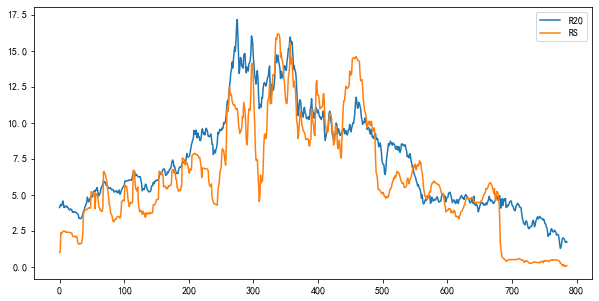

In [148]:
#引入数据
data=pd.read_csv("data/interest_rates.csv")
R20 = data.iloc[:, 1]
RS = data.iloc[:, 2]
#画图
plt.figure(figsize=[10, 5])
plt.plot(R20,label="R20")
plt.plot(RS,label="RS")
plt.legend()
plt.show()

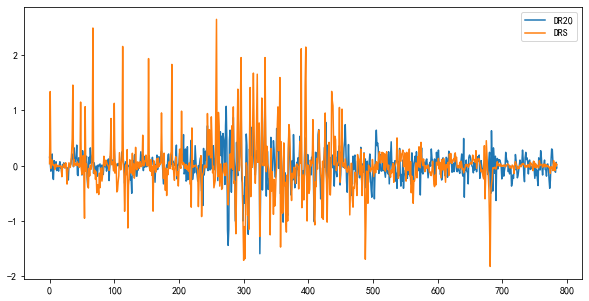

In [149]:
#引入数据
DR20 = np.diff(R20)
DRS = np.diff(RS)
#画图
plt.figure(figsize=[10, 5])
plt.plot(DR20,label="DR20")
plt.plot(DRS,label="DRS")
plt.legend()
plt.show()

#### 选择AIC

AIC是衡量统计模型拟合优良性的一种标准，又称赤池信息量准则。它建立在熵的概念基础上，可以权衡所估计模型的复杂度和此模型拟合数据的优良性。AIC越大表明模型拟合越优良，但考虑到避免过度拟合的情况，优先考虑AIC值最小的模型。

In [150]:
#通过AIC判断模型参数
def proper_model(data_ts, maxLag):
    init_bic = float("inf")
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel
# proper_model(trainSeting, 40)

可以得到，我们应该选择ADRL(2,1)模型。

#### 模型实现

根据此模型形式，我们可以假设为
$$
DR20_t = aDR20_{t-1} + bDR20_{t-2} + cDRS_t + dDRS_{t-1} + a_t
$$
此模型本质为多元线性回归

In [151]:
#引入数据
data = pd.read_csv("data/interest_rates_data.csv").iloc[:, :3]
target = pd.read_csv("data/interest_rates_data.csv").iloc[:, -1]
X = data
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=1)
lr = LinearRegression()
lr.fit(X_train, y_train)

print('lr.coef = ', lr.coef_)
print('lr.intercept = ', lr.intercept_)

lr.coef =  [ 0.13440093 -0.127763    0.23912426]
lr.intercept =  0.0006357329227839829


因此，最终模型为

$$
DR20_t = 0.13DR20_{t-1} - 0.13DR20_{t-2} + 0.24DRS_t - 0.0006DR20_{t-1}
$$

## 第十三章 向量自回归和格兰杰因果关系

### 多元动态回归模型

### 向量自回归模型（VAR）

####  VAR模型

以金融价格为例，传统的时间序列模型比如ARIMA,ARIMA-GARCH等，只分析价格自身的变化，模型的形式为：
$$
y_t = \beta_1*y_{t-1} + \beta_2*y_{t-2}+…
$$
其中$y_{t-1}$称为自身的滞后项。

但是VAR模型除了分析自身滞后项的影响外，还分析其他相关因素的滞后项对未来值产生的影响，模型的形式为：
$$
y_t = \beta_1*y_{t-1}+\alpha_1*x_{t-1}+\beta_2*y_{t-2}+\alpha_2*x_{t-2}+…
$$
其中$x_{t-1}$就是其他因子的滞后项。

####  VAR模型的建模步骤

1）画N个因子的序列相关图

2）对N个因子的原始数据进行平稳性检验，也就是ADF检验

3）对应变量（yt）和影响因子（Xt）做协整检验

4）通过AIC,BIC,以及LR定阶。

5）估计参数，看参数的显著性。

6）对参数进行稳定性检验

7）使用乔里斯基正交化残差进行脉冲响应分析

8）使用乔里斯基正交化残差进行方差分解分析

VAR建模的时候以上面的条件为例，其实模型估计参数时会给出三个3个方程(应变量各自不同）：

方程1：$y_t = \beta_1*y_{t-1}+\alpha_1*X1_{t-1}+\Theta_1*X2_{t-1}+\epsilon_t$

方程2：$X1_t = \beta_1*X1_{t-1}+\alpha_1*y_{t-1}+\Theta_1*X2_{t-1}+\eta_t$

方程3：$X2_t = \beta_1*X2_{t-1}+\alpha_1*y_{t-1}+\Theta_1*X1_{t-1}+w_t$

方程1的残差序列：$\epsilon_t$

方程2的残差序列：$\eta_t$

方差3的残差序列：$w_t$

**三个方程的乔里斯基正交化的步骤就是：**

正交1：$\frac{\eta_t}{\epsilon_t}$

正交2：$\frac{w_t}{\epsilon_t}$

正交3：$\frac{w_t}{\eta_t}$

正交4：$\frac{\frac{\eta_t}{\epsilon_t}}{\frac{\omega_t}{\epsilon_t}}$

正交5：$\frac{\frac{\eta_t}{\epsilon_t}}{\frac{\omega_t}{\eta_t}}$

最后用正交4/正交5，得到的序列就是乔里斯基正交化残差了。

### 格兰杰因果关系检验

​	格兰杰因果检验以自回归模型为基础，能够检验一组时间序列是否为另一组时间序列的原因，但并不是指真正意义上的因果关系而是一个变量对另一个变量的依存性。其基本观念是未来的事件不会对目前与过去产生因果影响，而过去的事件才可能对现在及未来产生影响。

​	格兰杰因果关系检验假设了有关y和x每一变量的预测的信息全部包含在这些变量的时间序列之中。检验要求估计以下的回归：
$$
y_t = \sum_{i-1}^q\alpha_ix_{i-1}+\sum_{j-1}^q\beta_jy_{t-j}+u_{1,t}
$$

$$
x_t = \sum_{i-1}^s\lambda_ix_{t-i}+\sum_{j-1}^s\delta_jy_{t-j}+u_{2,t}
$$

若在包含了变量x、y的过去信息下，对y的预测效果优于单独由y过去信息对y进行的预测效果，就认为x是引致y的格兰杰关系。

​	两个变量间存在四种情况：x是引起y变化的原因、y是引起x变化的原因、x与y互为因果关系、x与y独立。

###  例1 向量自回归模型的应用

#### **1）画序列相关图**

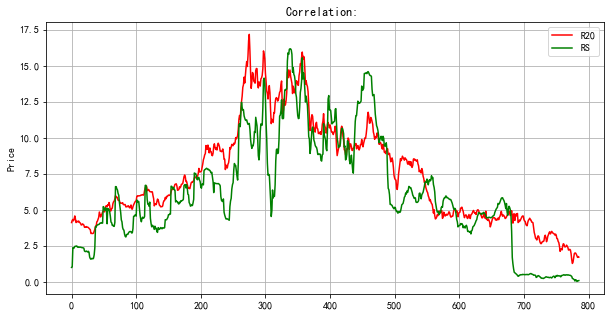

In [152]:
data = pd.read_csv("data/interest_rates.csv")
R20 = data.iloc[:, 1]
RS = data.iloc[:, 2]
fig = plt.figure(figsize=(10,5))
plt.plot(R20,'r',label='R20')
plt.plot(RS,'g',label='RS')
plt.title('Correlation: ')
plt.grid(True)
plt.axis('tight')
plt.legend(loc=0)
plt.ylabel('Price')
plt.show()

#### **2）ADF单位根**

python里的ADF检验结果就是下面的adfResult，这里用output整理了一下，方便浏览。

In [153]:
adfResult = sm.tsa.stattools.adfuller(R20, 3)
output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"],
					columns=['value'])
output['value']['Test Statistic Value'] = adfResult[0]
output['value']['p-value'] = adfResult[1]
output['value']['Lags Used'] = adfResult[2]
output['value']['Number of Observations Used'] = adfResult[3]
output['value']['Critical Value(1%)'] = adfResult[4]['1%']
output['value']['Critical Value(5%)'] = adfResult[4]['5%']
output['value']['Critical Value(10%)'] = adfResult[4]['10%']

#### **3）协整检验**

python里面的协整检验通过**coint（）这个函数进行的，返回P-value值，越小，说明协整关系越强**。

In [154]:
result = sm.tsa.stattools.coint(R20, RS)

#### **4）模型估计+定阶**

**这里插入的数据只能是DATAFRAME格式。**

**数据构造：**

In [155]:
lnDataDict = {'R20' : R20, 'RS' : RS}
lnDataDictSeries = pd.DataFrame(lnDataDict)
data = lnDataDictSeries[['R20', 'RS']]

#建立对象，dataframe就是前面的data，varLagNum就是你自己定的滞后阶数
orgMod = sm.tsa.VARMAX(data,order=(3,0),exog=None)
#估计：就是模型
fitMod = orgMod.fit(maxiter=1000,disp=False)
# 打印统计结果
print(fitMod.summary())
# 获得模型残差
resid = fitMod.resid
result = {'fitMod':fitMod,'resid':resid}

                           Statespace Model Results                           
Dep. Variable:          ['R20', 'RS']   No. Observations:                  786
Model:                         VAR(3)   Log Likelihood                -464.597
                          + intercept   AIC                            963.193
Date:                Sat, 15 Aug 2020   BIC                           1042.531
Time:                        16:37:18   HQIC                           993.697
Sample:                             0                                         
                                - 786                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                70.97, 69.62   Jarque-Bera (JB):      424.99, 1554.31
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.08, 0.27   Skew:                      -0.17, 1.09
Prob(H) (two-sided):            0.53,

#### **5）系数平稳检验：CUSUM检验**

这里的resid就是前面模型的resid

In [156]:
# 原假设：无漂移（平稳），备择假设：有漂移（不平稳）
result = statsmodels.stats.diagnostic.breaks_cusumolsresid(np.array(resid))

#### **6）脉冲响应图**

**orthogonalized=True代表使用乔里斯基正交。terms代表周期数。**

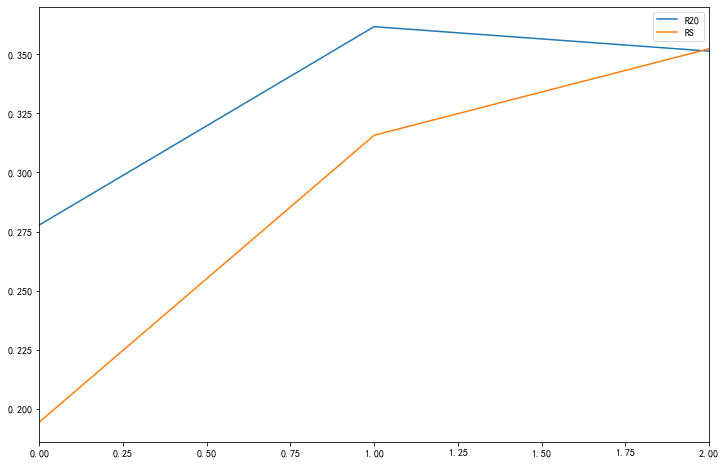

In [157]:
# orthogonalized=True，代表采用乔里斯基正交
ax = fitMod.impulse_responses(2, orthogonalized=True).plot(figsize=(12, 8))
plt.show()

#### **7）方差分解图**

这里就用VAR重新估计，然后直接使用**fevd进行方差分解**。

打印summary（）可以看到方差分解的具体结果，plot可以画图

In [158]:
md = sm.tsa.VAR(data)
re = md.fit(2)
fevd = re.fevd(10)
# 打印出方差分解的结果
fevd.summary()

FEVD for R20
          R20        RS
0    1.000000  0.000000
1    0.999736  0.000264
2    0.999597  0.000403
3    0.999594  0.000406
4    0.999649  0.000351
5    0.999709  0.000291
6    0.999751  0.000249
7    0.999763  0.000237
8    0.999741  0.000259
9    0.999684  0.000316

FEVD for RS
          R20        RS
0    0.209991  0.790009
1    0.279953  0.720047
2    0.321337  0.678663
3    0.347590  0.652410
4    0.365835  0.634165
5    0.379686  0.620314
6    0.390983  0.609017
7    0.400695  0.599305
8    0.409355  0.590645
9    0.417277  0.582723




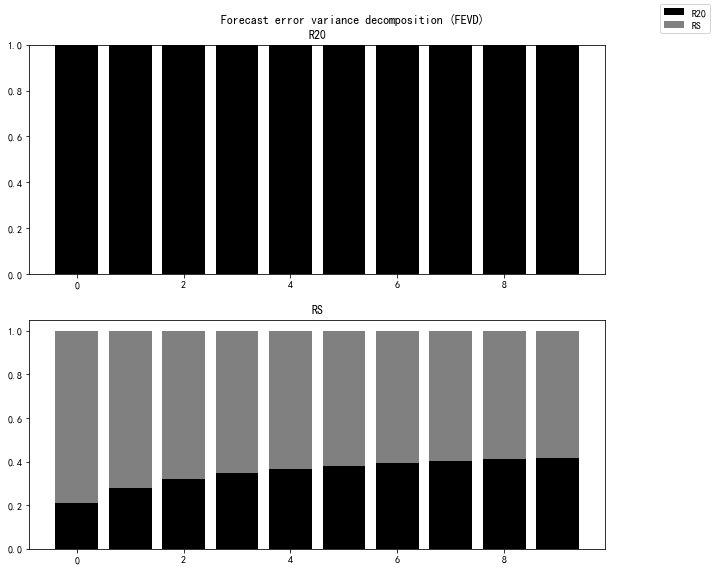

In [159]:
# 画图
fevd.plot(figsize=(10, 8))
plt.show()

### 结构向量自回归模型（SVAR）



​		结构向量自回归模型（SVAR) 可以捕捉模型系统内各个变量之间的即时的结构性关系。而如果仅仅建立一个VAR模型，这样的结构关联性却被转移到了随机扰动向量的方差-协方差矩阵中了。也正是基于这个原因，VAR模型实质上是一个缩减形式，没有明确体现变量间的结构性关系。

​		一个结构向量自回归模型可以写成为：
$$
B_0y_t=c_0+B_1y_1+B_2y_{t-2}+...+B_py_{t-p}+e_t
$$
其中：c0是n×1常数向量，Bi是n×n矩阵，et是n×1误差向量。

​		一个有两个变量的结构VAR(1)可以表示为
$$
\begin{pmatrix}
  1 & B_{0;1,2}\\
  B_{0;2,1} & 1 
 \end{pmatrix}
 \begin{pmatrix}
  y_{1,t} \\
  y_{2,t} 
 \end{pmatrix} = 
 \begin{pmatrix}
  c_{0;1} \\
  c_{0;2} 
 \end{pmatrix} +
\begin{pmatrix}
  B_{1;1,1} & B_{1;1,2}\\
  B_{1;2,1} & B_{1;2,2} 
 \end{pmatrix}+
 \begin{pmatrix}
  e_{1,t} \\
  e_{2,t} 
 \end{pmatrix}
$$
其中：
$$
\sum = E(e_te'_t)=\begin{pmatrix}
  \sigma_1 &0\\
  0 &\sigma_2
 \end{pmatrix}
$$
​		在一定的经济理论基础上的计量经济模型如果已经对各种冲击进行了显性的识别，那么这些模型通常可以变换为VAR或SVAR模型，VAR或SVAR模型是这些模型的简化式。但是有这些模型经过变换得到的VAR模型与一般的VAR模型并不完全相同，变现为两方面：

​		首先，这些模型经过变换得到的VAR模型是一种带有约束的VAR模型,我们可以通过约束检验和似然函数比例方法进行进一步检验来比较这两种模型。

​		其次，这些模型经过变换得到的VAR模型比一般的VAR模型有优越性的地方，但也有不足之处。通常这些模型对冲击进行了显性的识别，因而我们不需要进行冲击识别的过程，而一般的VAR模型所包含的冲击更为广泛，只有施加适当的识别条件，才能得到人们感兴趣的冲击，所以二者通常不能完全相互取代。

​		因此，要使这两种模型都避免Lucas批判(即当经济环境、政策体制、预期等发生变化导致深层次参数发生变化时，可能会导致模型中估计参数的变化及行为方程的不稳定,这将对政策分析和评价造成很大影响)，我们需要对这两种模型进行有关的外生性检验。

## 第十四章 误差修正、伪回归和协整

### 表14.1 线性回归两个独立的随机游走的统计信息

Granger和Newbold二人创立了以下时间序列信息生成过程（DGP）：

$$
y_t=\phi y_{t-1}+u_t \qquad u_t \sim i.i.d.(0, \sigma^2_u) \\
x_t=\phi^*x_{t-1}+v_t \qquad v_t \sim i.i.d.(0, \sigma^2_v)
$$

则$y_t$和$x_t$是不相关的一阶自回归过程。 由于$x_t$既不会影响$y_t$，也不会受到$y_t$的影响，因此应该希望回归模型中的系数$\beta_1$：

$$
y_t=\beta_0+\beta_1x_t+\epsilon_t
$$

会收敛到零，反映出这两个系列之间没有任何关系，正如该回归的$R^2$统计量一样。

当$\phi=\phi^*=1$时，两个序列为随机游走序列。这时我们对两序列的统计量t和$R^2$进行计算。

$$
t = \frac{|\hat{\beta}_1|}{se(\hat{\beta}_1)}
$$

有关生成随机游走的代码如下：

In [160]:
import numpy as np


def random_walk(x0, sigma, const, n):
    a = np.random.normal(0, sigma, n)
    xt = np.zeros(n)
    xt[0] = x0
    for i in range(1, n):
        xt[i] = xt[i-1] + a[i] + const
    return xt

接下来对统计量进行计算，累计生成1000次，每次生成两个长度为50的随机游走序列，计算统计量区间出现的频次。

首先设置生成随机序列的参数：

In [161]:
import pandas as pd
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings


warnings.filterwarnings('ignore')
np.random.seed(3)
nth = 1000
n = 50
count1 = count2 = 0
tlist, rlist, tcolumn, rcolumn = [[] for _ in range(4)]
tcal, rcal = [np.zeros(10) for _ in range(2)]
col = np.full(10, '')

循环生成1000次，并将每次的结果保存到列表中：

In [162]:
for i in range(nth):
    x = random_walk(0, 1, 0, n)
    y = random_walk(0, 1, 0, n)
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    temp1 = np.sum(np.power(y-slope*x-intercept, 2))/(n-2)
    temp2 = np.sum(np.power(x - np.mean(x), 2))
    se = np.sqrt(temp1/temp2)
    t = np.abs(slope)/se
    tlist.append(int(t/2))
    rlist.append(int(np.power(r_value, 2)*10))

分别对每个区间的频数进行统计：

In [163]:
for j in range(9):
    tcal[j] = tlist.count(j)
    rcal[j] = rlist.count(j)
    tcolumn.append(str(j * 2) + '-' + str(2 * (j + 1)))
    rcolumn.append(str(j / 10) + '-' + str((j + 1)/10))
for j in range(len(tlist)):
    if tlist[j] > 8:
        count1 += 1
    if rlist[j] > 8:
        count2 += 1
tcal[9], rcal[9] = count1, count2
tcolumn.append('>18')
rcolumn.append('0.9-1.0')

利用pandas将每个区间的结果打印出来：

In [164]:
df = np.append(np.append(tcolumn, tcal), np.append(rcolumn, rcal)).reshape([4, 10])
df = pd.DataFrame(df, index=['t-Statistics', '', 'R2 Statistics', ''], columns=col)
print(df)

                                                                              \
t-Statistics       0-2      2-4      4-6      6-8     8-10    10-12    12-14   
                 339.0    250.0    180.0    114.0     56.0     28.0     19.0   
R2 Statistics  0.0-0.1  0.1-0.2  0.2-0.3  0.3-0.4  0.4-0.5  0.5-0.6  0.6-0.7   
                 382.0    146.0    125.0     92.0     86.0     64.0     53.0   

                                          
t-Statistics     14-16    16-18      >18  
                   3.0      7.0      4.0  
R2 Statistics  0.7-0.8  0.8-0.9  0.9-1.0  
                  37.0     14.0      1.0  


### 图14.1 两个 I(0) 序列的相关系数的频数统计

u和v为白噪音序列，遵循标准正态分布。

现在要计算两个序列的皮尔逊相关系数，具体的实现代码如下：


In [165]:
def multipl(a, b):
    sumofab = 0.0
    for i in range(len(a)):
        temp = a[i] * b[i]
        sumofab += temp
    return sumofab


def corrcoef(x, y):
    n = len(x)
    sum1 = sum(x)
    sum2 = sum(y)
    sumofxy = multipl(x, y)
    sumofx2 = sum([pow(i, 2) for i in x])
    sumofy2 = sum([pow(j, 2) for j in y])
    num = sumofxy - (float(sum1) * float(sum2) / n)
    den = np.sqrt((sumofx2 - float(sum1 ** 2) / n) * (sumofy2 - float(sum2 ** 2) / n))
    return num / den

现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成u、v两个序列：

In [166]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    u = np.random.normal(0, 1, t)
    v = np.random.normal(0, 1, t)
    s = corrcoef(u, v)
    plist.append(s)

画出对应的频数图

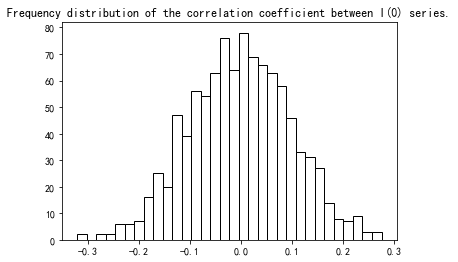

In [167]:
plt.figure()
plt.hist(plist, bins=32, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(0) series.')
plt.show()

### 图14.2 两个 I(1) 序列的相关系数的频数统计

x,y为两个随机游走序列，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成x、y两个序列：

In [168]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    x = random_walk(0, 1, 0, t)
    y = random_walk(0, 1, 0, t)
    s = corrcoef(x, y)
    plist.append(s)

画出对应的频数图

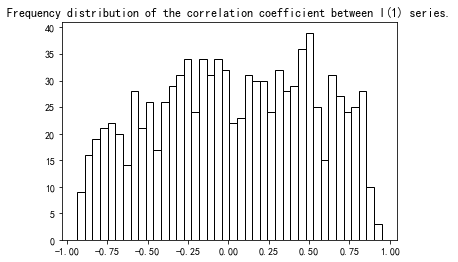

In [169]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(1) series.')
plt.show()

### 图14.3 两个 I(2) 序列的相关系数的频数统计

z、w为两个AR(2)，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先代码实现AR函数：

In [170]:
def autoregressive(phi, sigma, x0, const, n):
    k = len(phi)
    xt = np.zeros(n)
    a = np.random.normal(0, sigma, n)
    for i in range(k):
        xt[i] = x0[i]
    for i in range(k, n):
        temp = 0
        for t in range(k):
            temp += phi[t] * xt[i-t-1]
        xt[i] = temp + a[i] + const
    return xt

生成z、w两个序列：

In [171]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    z = autoregressive([2, -1], 1, [0, 0], 0, t)
    w = autoregressive([2, -1], 1, [0, 0], 0, t)
    s = corrcoef(z, w)
    plist.append(s)

画出对应的频数图

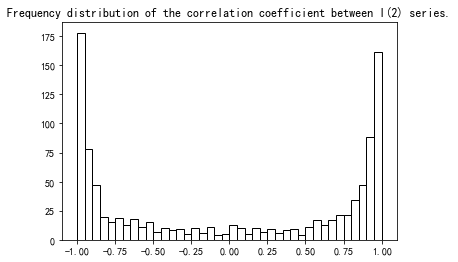

In [172]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(2) series.')
plt.show()

### 图14.3 I(1)和I(2) 序列的相关系数的频数统计

x为随机游走序列，z为AR(2)，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成z、x两个序列：

In [173]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    z = autoregressive([2, -1], 1, [0, 0], 0, t)
    x = random_walk(0, 1, 0, t)
    s = corrcoef(z, x)
    plist.append(s)

画出对应的频数图

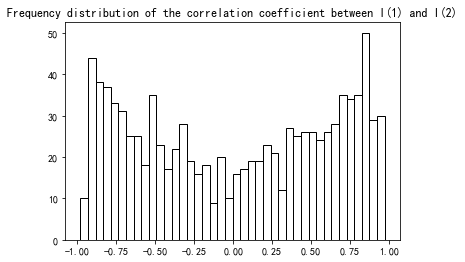

In [174]:
plt.figure()
plt.hist(plist, bins=40, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(1) and I(2)')
plt.show()

### 图14.3 I(0)和I(1) 序列的相关系数的频数统计

y为随机游走序列，v为白噪音，现在将两个序列生成1000次，每个序列的长度为100。统计皮尔逊相关系数的出现频次。

首先生成y、v两个序列：

In [175]:
np.random.seed(2)
n = 1000
t = 100
plist = []
for i in range(n):
    y = random_walk(0, 1, 0, t)
    v = np.random.normal(0, 1, t)
    s = corrcoef(y, v)
    plist.append(s)

画出对应的频数图

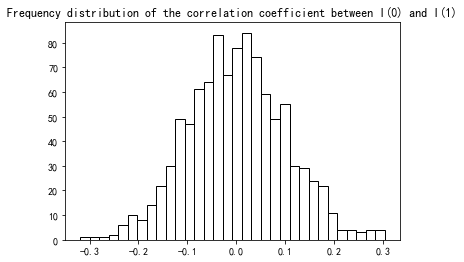

In [176]:
plt.figure()
plt.hist(plist, bins=32, facecolor="w", edgecolor="black")
plt.title('Frequency distribution of the correlation coefficient between I(0) and I(1)')
plt.show()

### 例14.1 英国利率是否为协整关系？

考虑到协整在具有集成变量的回归模型中所起的关键作用，测试其存在显然很重要。 检验可以基于协整回归的残差：

$$
\hat{e}_t=y_t-\hat{\beta}_0-\hat{\beta}_1x_{1,t}-...-\hat{\beta}_Mx_{M,t}
$$

这种基于残差的过程试图用单位根检验来检验没有协整的零假设。

ARDL模型的条件错误校正（CEC）形式为：

$$
\nabla y_t=\alpha_0+\alpha_1t-\phi(1)y_{t-1}+\sum_{j=1}^M\beta_j(1)x_{j,t-1}+\phi^*(B)\nabla y_{t-1}+\sum_{j=0}^M\gamma_j(B)\nabla x_{j,t}+a_t
$$

尽管上式是CEC的一般形式，但是有几种方法可以使常数和趋势进入误差校正。 例如，可以使$\alpha_0=\alpha_1=0$，得到以下的化简形式：

$$
\nabla y_t=-\phi(1)ec_{t-1}+\phi^*(B)\nabla y_{t-1}+\sum_{j=0}^M\gamma_j(B)\nabla x_{j,t}+a_t
$$

其中：

$$
ec_t=y_t-\sum_{j=1}^M\frac{\beta_j(1)}{\phi(1)}x_{j,t}
$$

在本题中，选取R20和RS的数据，分别进行回归。其中残差的关系如下：

$$
\hat{e}_{1,t}=R20_t-\hat{\beta}_0-\hat{\beta}_1RS_t \\
\hat{e}_{2,t}=RS_t-\hat{\beta}_0^{'}-\hat{\beta}_1R20_t
$$

首先读取interest rates数据：

In [177]:
data = pd.read_csv('data/interest_rates.csv')
temp = data.iloc[:, 0]
t = pd.to_datetime(data.iloc[:, 0], format='%Y-%m-%d')
r20 = np.array(data.iloc[:, 1])
rs = np.array(data.iloc[:, 2])

将R20与RS数据进行回归，得到以下结果：

In [178]:
k1 = st.linregress(rs, r20)
k2 = st.linregress(r20, rs)
print(k1)
print(k2)

LinregressResult(slope=0.7988615802015735, intercept=2.437830758360362, rvalue=0.8822278137604712, pvalue=1.0694382037998232e-258, stderr=0.015226154071853432)
LinregressResult(slope=0.9742938384597102, intercept=-1.0051785009305378, rvalue=0.8822278137604712, pvalue=1.0694382037998232e-258, stderr=0.01856986049060193)


## 第十五章 向量自回归与VEC模型

### 1.向量自回归与整合变量（Integrated Variables）

在这一章中，我们需要讨论带有I(1)的向量自回归过程。一般VAR模型的过程为
    一个n维时间序列${{Y_t}}$， 而且$$Y=C+\theta _{1}Y_{t-1}+\theta _{2}Y_{t-2}...+\theta _{p}Y_{t-p}+\varepsilon _{t}$$


其中$$E(\varepsilon )=0, E(\varepsilon {\varepsilon }')=\left\{\begin{matrix}
\pi  &  t=\tau  \\ 0
 &  t\neq \tau
\end{matrix}\right.$$


$\varepsilon$ 在不同时刻独立同分布，且服从正态分布，则称为p阶向量自回归模型。 

向量自回归模型的一般步骤为
* 对原始数据进行平稳性检验，也就是ADF检验
* 对应变量和自变量做协整检验
* LR（long-run）定阶
* 估计参数

In [179]:
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')#获取数据
dta.index = dta.qtr
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]

In [180]:
exog = endog['dln_consump']
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(2,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                            VARX(2)   Log Likelihood                 361.038
Date:                    Sat, 15 Aug 2020   AIC                           -696.075
Time:                            16:37:27   BIC                           -665.948
Sample:                        04-01-1960   HQIC                          -684.046
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                61.32, 39.29   Jarque-Bera (JB):          11.38, 2.39
Prob(Q):                        0.02, 0.50   Prob(JB):                   0.00, 0.30
Heteroskedasticity (H):         0.45, 0.40   Skew:                      0.16, -0.38
Prob(H) (two-sided):            0.05, 0.03   Kurtosis:                   4.88, 3.44


以上 为VAR（2）的一个估计实例

**向量自回归与协整变量（Cointegrated Variables）**

**协整** ：如果所考虑的时间序列具有相同的单整阶数，且某种协整向量使得组合时间序列的单整阶数降低，则称这些时间序列之间存在显著的协整关系。

### 例15.2

首先用VAR（2）估计rs 与rs20 这两个向量。估计时使用C作为外生变量。

In [181]:
df=pd.read_csv("data/interest_rates.csv")
df.head()
df.tail()

,t,r20,rs,c
781,2017/2/1,1.91,0.11,0.0
782,2017/3/1,1.81,0.02,0.0
783,2017/4/1,1.69,0.07,0.0
784,2017/5/1,1.75,0.06,0.0
785,2017/6/1,1.71,0.08,0.0


In [182]:
endog=df.iloc[:, 1:3]
ex=df.iloc[:, 3][:len(endog)]
endog
ex

0     -0.012296
1      0.233268
2     -0.081877
3     -0.113973
4      0.007990
         ...   
781    0.000000
782    0.000000
783    0.000000
784    0.000000
785    0.000000
Name: c, Length: 786, dtype: float64

In [183]:
mod = sm.tsa.VARMAX(endog, order=(2,0), trend='n', exog=ex)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:          ['r20', 'rs']   No. Observations:                  786
Model:                        VARX(2)   Log Likelihood                -471.866
Date:                Sat, 15 Aug 2020   AIC                            969.732
Time:                        16:37:33   BIC                           1030.403
Sample:                             0   HQIC                           993.059
                                - 786                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                84.83, 69.03   Jarque-Bera (JB):      500.59, 1545.30
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.09, 0.27   Skew:                      -0.31, 1.11
Prob(H) (two-sided):            0.50, 0.00   Kurtosis:                   6.86, 9.50
                           Resul

In [184]:
# 使用VAR(3)估计
mod = sm.tsa.VARMAX(endog, order=(3,0), trend='n', exog=ex)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:          ['r20', 'rs']   No. Observations:                  786
Model:                        VARX(3)   Log Likelihood                -465.031
Date:                Sat, 15 Aug 2020   AIC                            964.062
Time:                        16:37:40   BIC                           1043.400
Sample:                             0   HQIC                           994.565
                                - 786                                         
Covariance Type:                  opg                                         
Ljung-Box (Q):                71.39, 70.04   Jarque-Bera (JB):      442.09, 1576.01
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.06, 0.27   Skew:                      -0.24, 1.13
Prob(H) (two-sided):            0.64, 0.00   Kurtosis:                   6.64, 9.56
                           Resul

### 例15.3

检验VECM模型在英国利率上的表现

In [185]:
from statsmodels.tsa.vector_ar.vecm import VECM


model = VECM(endog = endog, k_ar_diff = 7, coint_rank = 6, deterministic = 'co')
res = model.fit()
X_pred = res.predict(steps=10)

X_pred

array([[1.6979118 , 0.09667496],
       [1.71062452, 0.14078442],
       [1.72545159, 0.18239104],
       [1.74792094, 0.24761231],
       [1.77330812, 0.31061977],
       [1.7841747 , 0.35616017],
       [1.798766  , 0.40489218],
       [1.81457573, 0.45199321],
       [1.82935881, 0.49685187],
       [1.84388115, 0.54088243]])

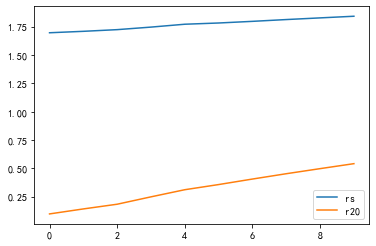

In [186]:
#预测结果
plt.plot(X_pred)
plt.legend(['rs',"r20"])
plt.show()

### 例15.4


In [187]:
from statsmodels.tsa.api import VAR,SVAR


np.ones((2,2))

array([[1., 1.],
       [1., 1.]])

In [188]:
model = VAR(endog)
results = model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     16:37:40
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.39319
Nobs:                     783.000    HQIC:                  -4.44450
Log likelihood:          -455.483    FPE:                  0.0113724
AIC:                     -4.47656    Det(Omega_mle):       0.0111718
--------------------------------------------------------------------
Results for equation r20
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.022874         0.024202            0.945           0.345
L1.r20         1.309279         0.040081           32.665           0.000
L1.rs         -0.009637         0.026347           -0.366           0.715
L2.r20        -0

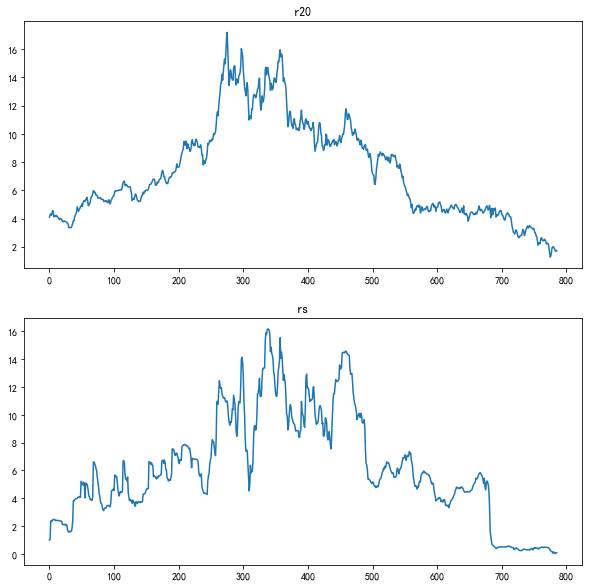

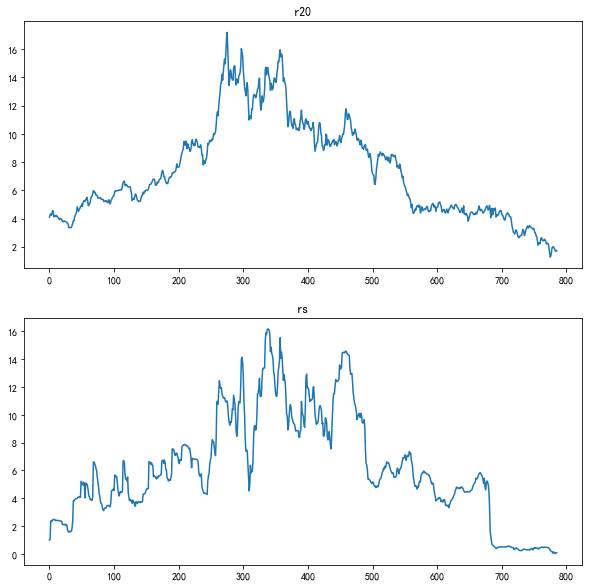

In [189]:
results.plot()

In [190]:
res=results.test_causality('rs', ['r20', 'rs'], kind='wald')
print(res)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: %s do not Granger-cause rs: reject at 5% significance level. Test statistic: 62868.469, critical value: 12.592>, p-value: 0.000>


In [191]:
results.to_vecm()

{'Gamma': array([[ 0.31604068, -0.01356378, -0.13601057,  0.01984455],
        [ 0.27155938,  0.22646186, -0.07699749,  0.0388359 ]]),
 'Pi': array([[-0.00676172,  0.00392675],
        [ 0.02322247, -0.02714869]])}

### 例15.5 LA-VAR causality tests for U.K. interest rates

In [192]:
model = VAR(endog)
results = model.fit(4)
res=results.test_causality('rs', ['r20', 'rs'])
print(res)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: %s do not Granger-cause rs: reject at 5% significance level. Test statistic: 7827.480, critical value: 1.944>, p-value: 0.000>


### 例15.6 

In [193]:
model = VECM(endog = endog, k_ar_diff = 2, coint_rank = 1, deterministic = 'co')
res = model.fit()
res.conf_int_det_coef_coint()

array([], shape=(0, 1), dtype=[('lower', '<f8'), ('upper', '<f8')])

### 例15.7

In [194]:
data=pd.read_csv("data/global_forcings.csv")
data

,t,amo,soi,temp,trf,volc
0,1866-01-01,0.205083,-0.025000,0.058267,0.155966,0.219079
1,1867-01-01,0.143583,-0.008333,-0.010733,0.150523,0.229017
2,1868-01-01,0.155917,-0.138333,0.072267,0.173692,0.231073
3,1869-01-01,0.097083,0.062500,0.041267,0.217857,0.222848
4,1870-01-01,0.020000,-0.026667,0.028267,0.251133,0.218736
...,...,...,...,...,...,...
145,2011/1/1,0.101667,0.228333,0.725267,2.282982,0.000000
146,2012/1/1,0.213333,-0.019167,0.773267,2.342985,0.000000
147,2013/1/1,0.166500,0.041667,0.802267,2.374454,0.000000
148,2014/1/1,0.102250,-0.068333,0.870267,2.376194,0.000000


In [195]:
endog=data.iloc[:, 3:5].copy()
exo=data.iloc[:, [1, 2, 5]].copy()
amo=data.iloc[:, 1].copy()
exo["amo(-1)"]=amo.shift(-1)
endog=endog[:-1]
exo=exo.dropna()
exo

,amo,soi,volc,amo(-1)
0,0.205083,-0.025000,0.219079,0.143583
1,0.143583,-0.008333,0.229017,0.155917
2,0.155917,-0.138333,0.231073,0.097083
3,0.097083,0.062500,0.222848,0.020000
4,0.020000,-0.026667,0.218736,0.033167
...,...,...,...,...
144,0.348917,0.132500,0.000000,0.101667
145,0.101667,0.228333,0.000000,0.213333
146,0.213333,-0.019167,0.000000,0.166500
147,0.166500,0.041667,0.000000,0.102250


In [196]:
model = statsmodels.tsa.vector_ar.vecm.VECM(endog,exog=exo,k_ar_diff = 4, coint_rank = 2, deterministic = 'co')
results = model.fit()
print(results.summary(alpha=0.05))

Det. terms outside the coint. relation & lagged endog. parameters for equation temp
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0567      0.013     -4.517      0.000      -0.081      -0.032
exog1          0.3125      0.050      6.275      0.000       0.215       0.410
exog2         -0.3637      0.056     -6.531      0.000      -0.473      -0.255
exog3          0.0748      0.021      3.597      0.000       0.034       0.116
exog4         -0.0141      0.047     -0.302      0.762      -0.106       0.078
L1.temp       -0.1102      0.080     -1.377      0.169      -0.267       0.047
L1.trf        -0.0225      0.516     -0.044      0.965      -1.034       0.989
L2.temp       -0.0968      0.072     -1.348      0.178      -0.238       0.044
L2.trf        -0.4081      0.893     -0.457      0.648      -2.159       1.343
L3.temp       -0.0974      0.064     -1.524    

## 第十六章 组合与计数时间序列

### 例16.1

在前面的章节中， 我们考虑到时间序列通常没有任何限制，除了它们有一 个自然的下界，这通常是零。然而，有一些级数或级数的组受到进一步的 约束。在对这样的序列建模时，一个 “好的”模型应该不能预测违反已知 约束的值， 也就是说，这个模型应该是 “ 预测一致的 ” 。“本章考虑这类 级数的两个例子:(1)复合时间序列，其中一组级数被定义为一个整体的份额， 因此它们必须是加起来等于一的正分数 ;(2)“计数”时间序列只能取正的、 通常较低的整数值。

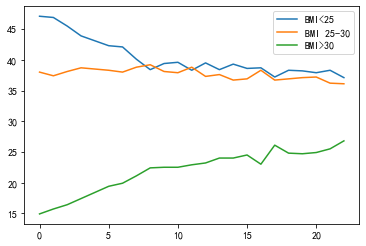

In [197]:
df=pd.read_csv("data/obesity.csv")
x1=np.array(df.iloc[:, 1])
x2=np.array(df.iloc[:, 2])
x3=np.array(df.iloc[:, 3])
plt.plot(x1)
plt.plot(x2)
plt.plot(x3)
plt.legend(['BMI<25',"BMI 25-30","BMI>30"])
plt.show()

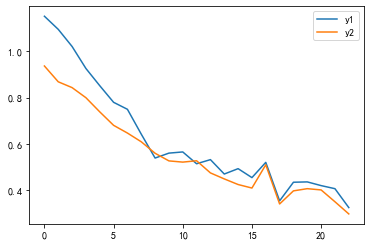

In [198]:
y1 = np.log(x1/x3)
y2 = np.log(x2/x3)
plt.plot(y1)
plt.plot(y2)
plt.legend(["y1","y2"])
plt.show()
y1=pd.Series(y1).dropna()
y2=pd.Series(y2).dropna()

In [199]:
x1=np.array(range(len(y1)))
X=np.column_stack(((x1), (x1)**2, (x1)**3))

olsmod1 = sm.OLS(y1, X)
olsres1 = olsmod1.fit()
print(olsres1.summary())
olsmod2 = sm.OLS(y2, X)
olsres2 = olsmod2.fit()
print(olsres2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.720
Model:                            OLS   Adj. R-squared (uncentered):              0.678
Method:                 Least Squares   F-statistic:                              17.16
Date:                Sat, 15 Aug 2020   Prob (F-statistic):                    9.41e-06
Time:                        16:37:41   Log-Likelihood:                         -8.5158
No. Observations:                  23   AIC:                                      23.03
Df Residuals:                      20   BIC:                                      26.44
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [200]:
x2=np.array(range(len(y1)+5))
X2=np.column_stack(((x2), (x2)**2, (x2)**3))
y1_f = olsres1.predict(X2)
y2_f= olsres2.predict(X2)

x1_f = 100*np.exp(y1_f)/(1 + np.exp(y1_f) + np.exp(y2_f))
x2_f = 100*np.exp(y2_f)/(1 + np.exp(y1_f) + np.exp(y2_f))
x3_f = 100 -x1_f - x2_f

### 例16.2

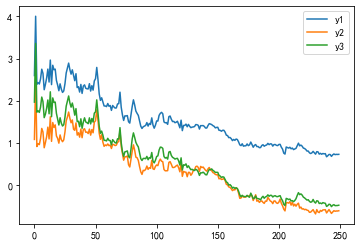

In [201]:
df=pd.read_csv("data/tfe_shares.csv")
x=np.array(df.iloc[:, 4])
c=np.array(df.iloc[:, 1])
g=np.array(df.iloc[:, 2])
i=np.array(df.iloc[:, 3])

y1 = np.log(c/x)
y2 = np.log(i/x)
y3 = np.log(g/x)
plt.plot(y1)
plt.plot(y2)
plt.plot(y3)
plt.legend(["y1","y2","y3"])
plt.show()
y1=pd.Series(y1).dropna()
y2=pd.Series(y2).dropna()
y3=pd.Series(y3).dropna()

In [202]:
endog=np.column_stack((y1, y2, y3))
model = VAR(endog)
results = model.fit(3)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     16:37:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -19.4086
Nobs:                     247.000    HQIC:                  -19.6632
Log likelihood:           1428.16    FPE:                2.43171e-09
AIC:                     -19.8348    Det(Omega_mle):     2.15875e-09
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.221553         0.113086            1.959           0.050
L1.y1         0.559874         0.575851            0.972           0.331
L1.y2         0.033983         0.261057            0.130           0.896
L1.y3         0.204065

### 例16.3

In [203]:
df=pd.read_csv("data/hurricanes.csv")
df.head()

,t,hurricanes,storms
0,1851-01-01,3,6
1,1852-01-01,5,5
2,1853-01-01,4,8
3,1854-01-01,3,5
4,1855-01-01,4,5


In [204]:
x=np.array(df.iloc[:, 2])
r1 = 0.384
r2 = 0.300
phi2 = 0.179
score = np.sqrt(x)*r1
y = x -np.mean(x)
s = np.sum(y)

y2 = pd.Series(x).shift(-2) - np.mean(x)
y1 = y*y2
s1 = np.sum(y1)
qacf = (r2**2)*(s**2)/s1
qpacf = (phi2**2)*(s**2)/s1

r1 = 0.384
r2 = 0.300
a = (x*r1 + 1)/(x - 3)
l1 = (1 - a)*np.mean(x)
a1 = r1*(1 - r2)/(1 - r1**2)
a2 = (r2 - r1**2)/(1 - r1**2)
l2 =  (1 - a1 -a2)*np.mean(x)
w1 = x - a*pd.Series(x).shift(-1) - l1
w2 = x - a1*pd.Series(x).shift(-1) - a2*pd.Series(x).shift(-1) - l2